# Demo

In this notebook, we reproduced the original demo within this HDDM docker container. Also, we demonstrated how to use `p_tqdm` for parallel processing.

This script reproduces the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) by the HDDM (0.9.0) in this docker image.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki

print(hddm.__version__)

0.9.0


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.8/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv(
    "/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv"
)
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


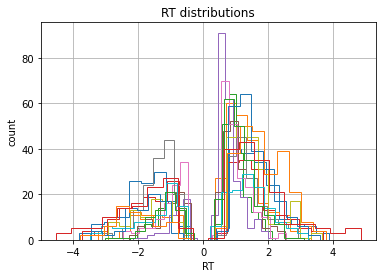

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="RT", ylabel="count", title="RT distributions")
for i, subj_data in data.groupby("subj_idx"):
    subj_data.rt.hist(bins=20, histtype="step", ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(["subj_idx", "stim"]).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m1 = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m1.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 93.7 sec

In [9]:
stats = m1.gen_stats()
stats[stats.index.isin(["a", "a_std", "a_subj.0", "a_subj.1"])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97752,0.0957193,1.80064,1.91064,1.97576,2.03826,2.16793,0.00286307
a_std,0.341026,0.0798625,0.22049,0.286167,0.327486,0.384362,0.524677,0.00255732
a_subj.0,2.20031,0.0651742,2.07765,2.15607,2.19816,2.24264,2.33024,0.00222415
a_subj.1,2.11716,0.0683339,1.98541,2.06995,2.11599,2.16298,2.2559,0.00264936


Plotting a
Plotting a_std
Plotting v
Plotting t


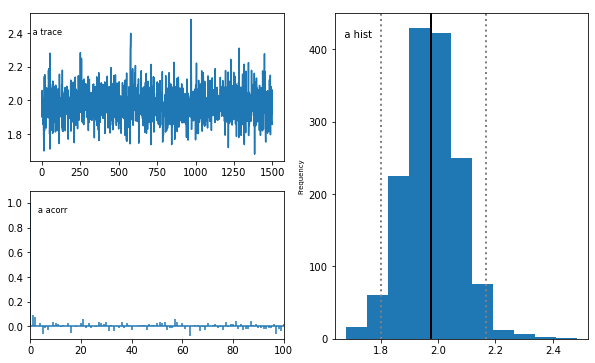

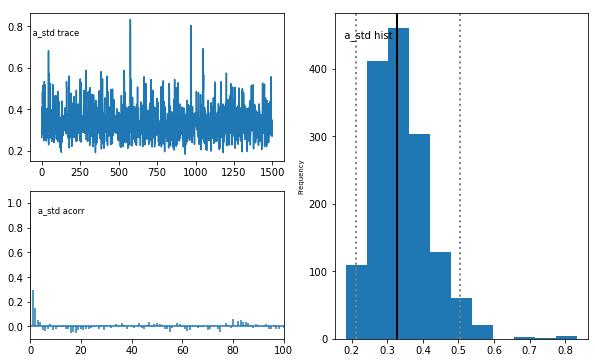

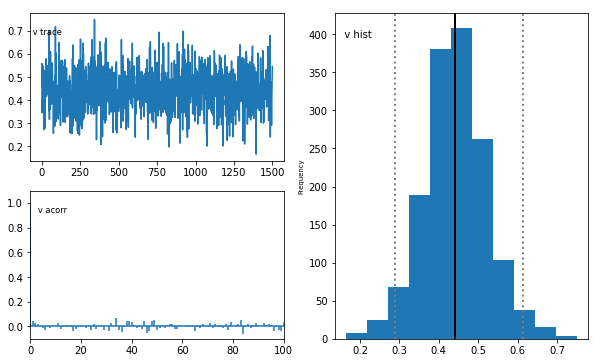

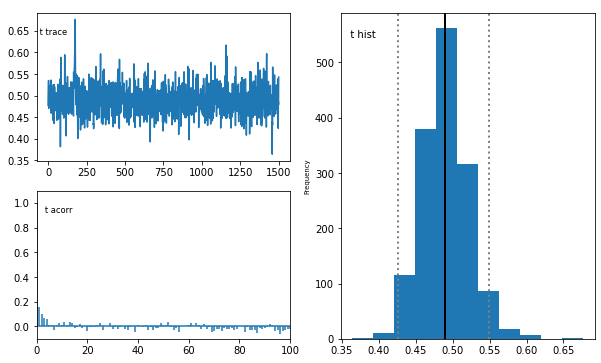

In [10]:
m1.plot_posteriors(["a", "t", "v", "a_std"])

## Calculate Gelman_rubin r hat.

### Option 1: using`for` loop

As we can see, it takes 20min 32s on a machine with `Intel® Core™ i7-10700 CPU @ 2.90GHz × 16` 

In [11]:
samples = 5000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 1000
thin = 1
chains = 5

In [12]:
%%time
models_1_ser = []
for i in range(chains):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(samples, burn=burn)
    models_1_ser.append(m)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 239.0 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 240.3 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 237.6 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 235.3 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 235.6 secCPU times: user 19min 54s, sys: 54.4 s, total: 20min 49s
Wall time: 19min 52s


In [13]:
hddm.analyze.gelman_rubin(models_1_ser)

{'a': 0.9999651733536193,
 'a_std': 1.000715362921017,
 'a_subj.0': 1.0000381540666285,
 'a_subj.1': 1.000277238034722,
 'a_subj.2': 1.000093898966081,
 'a_subj.3': 1.0000761837782841,
 'a_subj.4': 0.9999311972650973,
 'a_subj.5': 1.0001190934309006,
 'a_subj.6': 0.9999199383362449,
 'a_subj.7': 1.0001856976780268,
 'a_subj.8': 1.0001308773942077,
 'a_subj.9': 1.0002110583090371,
 'a_subj.10': 1.0001907458400503,
 'a_subj.11': 1.0003310659326172,
 'a_subj.12': 1.000074067003067,
 'a_subj.13': 1.000283112938863,
 'v': 0.9998957058284431,
 'v_std': 1.000064020651213,
 'v_subj.0': 1.0002914435290953,
 'v_subj.1': 1.000178559778902,
 'v_subj.2': 0.9999792628213052,
 'v_subj.3': 0.9999187466258814,
 'v_subj.4': 0.9999960407102503,
 'v_subj.5': 0.9999164854589074,
 'v_subj.6': 0.9999586249408142,
 'v_subj.7': 0.9998843288180914,
 'v_subj.8': 0.9999385094011076,
 'v_subj.9': 1.0000503140297066,
 'v_subj.10': 1.0000275300922934,
 'v_subj.11': 0.999944821810954,
 'v_subj.12': 1.0000607499198928

### Option 2: using `p_tqdm` for parall processing
Here, we replace the `for` loop with parallel processing. As we can see here, the parall processing takes 4min 1s minutes on the same machine. 

In [14]:
# parallel processing related packages
from p_tqdm import p_map
from functools import partial

In [15]:
def ms1(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m1"):
    print("running model%i" % id)

    import hddm

    dbname = save_name + "_chain_%i.db" % id
    mname = save_name + "_chain_%i" % id
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(
        samples, burn=burn, dbname=dbname, db="pickle"
    )  # it's neccessary to save the model data
    m.save(mname)

    return m

In [16]:
%%time
models_1_par = p_map(
    partial(ms1, data=data, samples=samples, burn=burn), range(chains)
)  # progess bar is a mess ;(

running model0

  0%|          | 0/5 [00:00<?, ?it/s]


No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model1
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model2
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model4
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


 [-                 5%                  ] 254 of 5000 complete in 12.0 sec[--                5%                  ] 266 of 5000 complete in 12.3 sec[--                5%                  ] 267 of 5000 complete in 12.4 sec[--                5%                  ] 269 of 5000 complete in 12.5 sec[--                5%                  ] 267 of 5000 complete in 12.5 sec[--                5%                  ] 265 of 5000 complete in 12.5 sec[--                5%                  ] 277 of 5000 complete in 12.9 sec[--                5%                  ] 279 of 5000 complete in 12.9 sec[--                5%                  ] 280 of 5000 complete in 13.0 sec[--                5%                  ] 278 of 5000 complete in 13.0 sec[--                5%                  ] 276 of 5000 complete in 13.0 sec[--                5%                  ] 288 of 5000 complete in 13.4 sec[--                5%                  ] 291 of 5000 complete in 13.5 sec[--                5%                  ] 291 of 50

 [---              10%                  ] 509 of 5000 complete in 23.9 sec[---              10%                  ] 515 of 5000 complete in 23.9 sec[---              10%                  ] 509 of 5000 complete in 23.9 sec[---              10%                  ] 522 of 5000 complete in 24.2 sec[---              10%                  ] 519 of 5000 complete in 24.3 sec[---              10%                  ] 521 of 5000 complete in 24.4 sec[---              10%                  ] 526 of 5000 complete in 24.4 sec[---              10%                  ] 521 of 5000 complete in 24.4 sec[----             10%                  ] 530 of 5000 complete in 24.8 sec[----             10%                  ] 534 of 5000 complete in 24.8 sec[----             10%                  ] 532 of 5000 complete in 24.9 sec[----             10%                  ] 537 of 5000 complete in 25.0 sec[----             10%                  ] 532 of 5000 complete in 24.9 sec[----             10%                  ] 541 of 50

 [-----            15%                  ] 764 of 5000 complete in 35.7 sec[-----            15%                  ] 769 of 5000 complete in 35.7 sec[-----            15%                  ] 767 of 5000 complete in 35.8 sec[-----            15%                  ] 770 of 5000 complete in 35.9 sec[-----            15%                  ] 767 of 5000 complete in 36.0 sec[-----            15%                  ] 775 of 5000 complete in 36.2 sec[-----            15%                  ] 780 of 5000 complete in 36.2 sec[-----            15%                  ] 778 of 5000 complete in 36.3 sec[-----            15%                  ] 781 of 5000 complete in 36.4 sec[-----            15%                  ] 778 of 5000 complete in 36.5 sec[-----            15%                  ] 786 of 5000 complete in 36.7 sec[------           15%                  ] 791 of 5000 complete in 36.7 sec[-----            15%                  ] 789 of 5000 complete in 36.9 sec[------           15%                  ] 792 of 50

 [-------          20%                  ] 1012 of 5000 complete in 47.4 sec[-------          20%                  ] 1007 of 5000 complete in 47.4 sec[-------          20%                  ] 1022 of 5000 complete in 47.8 sec[-------          20%                  ] 1017 of 5000 complete in 47.8 sec[-------          20%                  ] 1019 of 5000 complete in 47.8 sec[-------          20%                  ] 1023 of 5000 complete in 48.0 sec[-------          20%                  ] 1018 of 5000 complete in 47.9 sec[-------          20%                  ] 1033 of 5000 complete in 48.3 sec[-------          20%                  ] 1028 of 5000 complete in 48.3 sec[-------          20%                  ] 1030 of 5000 complete in 48.3 sec[-------          20%                  ] 1034 of 5000 complete in 48.5 sec[-------          20%                  ] 1029 of 5000 complete in 48.4 sec[-------          20%                  ] 1044 of 5000 complete in 48.8 sec[-------          20%                

 [---------        24%                  ] 1248 of 5000 complete in 58.9 sec[---------        25%                  ] 1258 of 5000 complete in 59.2 sec[---------        25%                  ] 1261 of 5000 complete in 59.3 sec[---------        25%                  ] 1257 of 5000 complete in 59.3 sec[---------        25%                  ] 1268 of 5000 complete in 59.4 sec[---------        25%                  ] 1259 of 5000 complete in 59.5 sec[---------        25%                  ] 1269 of 5000 complete in 59.8 sec[---------        25%                  ] 1272 of 5000 complete in 59.8 sec[---------        25%                  ] 1268 of 5000 complete in 59.8 sec[---------        25%                  ] 1279 of 5000 complete in 60.0 sec[---------        25%                  ] 1270 of 5000 complete in 60.0 sec[---------        25%                  ] 1282 of 5000 complete in 60.3 sec[---------        25%                  ] 1280 of 5000 complete in 60.3 sec[---------        25%                

 [-----------      29%                  ] 1498 of 5000 complete in 70.7 sec[-----------      30%                  ] 1503 of 5000 complete in 70.8 sec[-----------      29%                  ] 1499 of 5000 complete in 70.8 sec[-----------      30%                  ] 1510 of 5000 complete in 71.0 sec[-----------      29%                  ] 1499 of 5000 complete in 71.1 sec[-----------      30%                  ] 1510 of 5000 complete in 71.2 sec[-----------      30%                  ] 1514 of 5000 complete in 71.3 sec[-----------      30%                  ] 1510 of 5000 complete in 71.3 sec[-----------      30%                  ] 1521 of 5000 complete in 71.5 sec[-----------      30%                  ] 1509 of 5000 complete in 71.6 sec[-----------      30%                  ] 1521 of 5000 complete in 71.8 sec[-----------      30%                  ] 1524 of 5000 complete in 71.8 sec[-----------      30%                  ] 1521 of 5000 complete in 71.9 sec[-----------      30%                

 [-------------    34%                  ] 1745 of 5000 complete in 82.2 sec[-------------    34%                  ] 1739 of 5000 complete in 82.4 sec[-------------    35%                  ] 1750 of 5000 complete in 82.5 sec[-------------    34%                  ] 1737 of 5000 complete in 82.5 sec[-------------    35%                  ] 1752 of 5000 complete in 82.7 sec[-------------    35%                  ] 1756 of 5000 complete in 82.7 sec[-------------    35%                  ] 1751 of 5000 complete in 82.9 sec[-------------    35%                  ] 1761 of 5000 complete in 83.0 sec[-------------    34%                  ] 1749 of 5000 complete in 83.1 sec[-------------    35%                  ] 1763 of 5000 complete in 83.2 sec[-------------    35%                  ] 1767 of 5000 complete in 83.2 sec[-------------    35%                  ] 1762 of 5000 complete in 83.5 sec[-------------    35%                  ] 1772 of 5000 complete in 83.6 sec[-------------    35%                

 [---------------  39%                  ] 1980 of 5000 complete in 94.0 sec[---------------  39%                  ] 1993 of 5000 complete in 94.0 sec[---------------  39%                  ] 1997 of 5000 complete in 94.2 sec[---------------  39%                  ] 1995 of 5000 complete in 94.2 sec[---------------  39%                  ] 1981 of 5000 complete in 94.2 sec[---------------  39%                  ] 1991 of 5000 complete in 94.5 sec[---------------  40%                  ] 2004 of 5000 complete in 94.6 sec[---------------  40%                  ] 2008 of 5000 complete in 94.7 sec[---------------  40%                  ] 2006 of 5000 complete in 94.7 sec[---------------  39%                  ] 1992 of 5000 complete in 94.7 sec[---------------  40%                  ] 2002 of 5000 complete in 95.0 sec[---------------  40%                  ] 2015 of 5000 complete in 95.1 sec[---------------  40%                  ] 2017 of 5000 complete in 95.2 sec[---------------  40%                

 [---------------- 44%                  ] 2222 of 5000 complete in 105.6 sec[---------------- 44%                  ] 2236 of 5000 complete in 105.7 sec[---------------- 44%                  ] 2224 of 5000 complete in 105.6 sec[-----------------44%                  ] 2242 of 5000 complete in 105.7 sec[-----------------45%                  ] 2250 of 5000 complete in 106.1 sec[---------------- 44%                  ] 2233 of 5000 complete in 106.1 sec[-----------------44%                  ] 2247 of 5000 complete in 106.2 sec[-----------------45%                  ] 2253 of 5000 complete in 106.2 sec[---------------- 44%                  ] 2236 of 5000 complete in 106.2 sec[-----------------45%                  ] 2261 of 5000 complete in 106.6 sec[-----------------44%                  ] 2244 of 5000 complete in 106.6 sec[-----------------45%                  ] 2258 of 5000 complete in 106.7 sec[-----------------45%                  ] 2264 of 5000 complete in 106.8 sec[-----------------44%   

 [-----------------49%                  ] 2483 of 5000 complete in 117.1 sec[-----------------49%                  ] 2479 of 5000 complete in 117.2 sec[-----------------49%                  ] 2469 of 5000 complete in 117.2 sec[-----------------49%                  ] 2481 of 5000 complete in 117.3 sec[-----------------49%                  ] 2473 of 5000 complete in 117.6 sec[-----------------49%                  ] 2495 of 5000 complete in 117.7 sec[-----------------49%                  ] 2490 of 5000 complete in 117.7 sec[-----------------49%                  ] 2481 of 5000 complete in 117.8 sec[-----------------49%                  ] 2492 of 5000 complete in 117.8 sec[-----------------49%                  ] 2484 of 5000 complete in 118.1 sec[-----------------50%                  ] 2506 of 5000 complete in 118.2 sec[-----------------50%                  ] 2501 of 5000 complete in 118.2 sec[-----------------49%                  ] 2492 of 5000 complete in 118.3 sec[-----------------50%   

 [-----------------54%                  ] 2728 of 5000 complete in 128.6 sec[-----------------54%                  ] 2723 of 5000 complete in 128.7 sec[-----------------54%                  ] 2712 of 5000 complete in 128.7 sec[-----------------54%                  ] 2725 of 5000 complete in 128.9 sec[-----------------54%                  ] 2711 of 5000 complete in 129.0 sec[-----------------54%                  ] 2739 of 5000 complete in 129.2 sec[-----------------54%                  ] 2734 of 5000 complete in 129.2 sec[-----------------54%                  ] 2723 of 5000 complete in 129.3 sec[-----------------54%                  ] 2736 of 5000 complete in 129.5 sec[-----------------54%                  ] 2722 of 5000 complete in 129.5 sec[-----------------55%                  ] 2750 of 5000 complete in 129.7 sec[-----------------54%                  ] 2745 of 5000 complete in 129.8 sec[-----------------54%                  ] 2734 of 5000 complete in 129.8 sec[-----------------54%   

 -----------------62%---               ] 3133 of 5000 complete in 147.9 secc[-----------------59%--                ] 2966 of 5000 complete in 140.2 sec[-----------------59%--                ] 2951 of 5000 complete in 140.3 sec[-----------------59%--                ] 2968 of 5000 complete in 140.4 sec[-----------------59%--                ] 2956 of 5000 complete in 140.5 sec[-----------------59%--                ] 2978 of 5000 complete in 140.6 sec[-----------------59%--                ] 2977 of 5000 complete in 140.7 sec[-----------------59%--                ] 2962 of 5000 complete in 140.8 sec[-----------------59%--                ] 2979 of 5000 complete in 140.9 sec[-----------------59%--                ] 2967 of 5000 complete in 141.0 sec[-----------------59%--                ] 2989 of 5000 complete in 141.1 sec[-----------------59%--                ] 2988 of 5000 complete in 141.2 sec[-----------------59%--                ] 2973 of 5000 complete in 141.3 sec[-----------------59%-- 

 [-----------------64%----              ] 3203 of 5000 complete in 151.8 sec[-----------------64%----              ] 3211 of 5000 complete in 151.9 sec[-----------------63%----              ] 3194 of 5000 complete in 151.9 sec[-----------------63%----              ] 3196 of 5000 complete in 152.1 sec[-----------------64%----              ] 3222 of 5000 complete in 152.1 sec[-----------------64%----              ] 3214 of 5000 complete in 152.3 sec[-----------------64%----              ] 3222 of 5000 complete in 152.4 sec[-----------------64%----              ] 3205 of 5000 complete in 152.4 sec[-----------------64%----              ] 3207 of 5000 complete in 152.6 sec[-----------------64%----              ] 3233 of 5000 complete in 152.6 sec[-----------------64%----              ] 3226 of 5000 complete in 152.9 sec[-----------------64%----              ] 3233 of 5000 complete in 152.9 sec[-----------------64%----              ] 3216 of 5000 complete in 152.9 sec[-----------------64%---

 -----------------69%------            ] 3479 of 5000 complete in 165.5 secc[-----------------68%------            ] 3445 of 5000 complete in 163.5 sec[-----------------68%------            ] 3435 of 5000 complete in 163.4 sec[-----------------68%------            ] 3438 of 5000 complete in 163.6 sec[-----------------69%------            ] 3460 of 5000 complete in 163.6 sec[-----------------69%------            ] 3469 of 5000 complete in 163.9 sec[-----------------69%------            ] 3456 of 5000 complete in 164.0 sec[-----------------68%------            ] 3446 of 5000 complete in 163.9 sec[-----------------68%------            ] 3449 of 5000 complete in 164.1 sec[-----------------69%------            ] 3472 of 5000 complete in 164.1 sec[-----------------69%------            ] 3480 of 5000 complete in 164.5 sec[-----------------69%------            ] 3467 of 5000 complete in 164.5 sec[-----------------69%------            ] 3457 of 5000 complete in 164.5 sec[-----------------69%---

 [-----------------74%--------          ] 3702 of 5000 complete in 174.9 sec[-----------------73%-------           ] 3684 of 5000 complete in 175.0 sec[-----------------73%-------           ] 3681 of 5000 complete in 175.1 sec[-----------------74%--------          ] 3703 of 5000 complete in 175.2 sec[-----------------73%--------          ] 3688 of 5000 complete in 175.3 sec[-----------------74%--------          ] 3713 of 5000 complete in 175.4 sec[-----------------73%--------          ] 3695 of 5000 complete in 175.5 sec[-----------------73%--------          ] 3692 of 5000 complete in 175.7 sec[-----------------74%--------          ] 3714 of 5000 complete in 175.7 sec[-----------------73%--------          ] 3699 of 5000 complete in 175.8 sec[-----------------74%--------          ] 3724 of 5000 complete in 175.9 sec[-----------------74%--------          ] 3705 of 5000 complete in 176.0 sec[-----------------74%--------          ] 3703 of 5000 complete in 176.2 sec[-----------------74%---

 [-----------------78%---------         ] 3942 of 5000 complete in 186.3 sec[-----------------78%---------         ] 3927 of 5000 complete in 186.5 sec[-----------------78%---------         ] 3920 of 5000 complete in 186.6 sec[-----------------78%---------         ] 3945 of 5000 complete in 186.7 sec[-----------------78%---------         ] 3931 of 5000 complete in 186.7 sec[-----------------79%----------        ] 3953 of 5000 complete in 186.8 sec[-----------------78%---------         ] 3938 of 5000 complete in 187.0 sec[-----------------78%---------         ] 3931 of 5000 complete in 187.1 sec[-----------------79%----------        ] 3956 of 5000 complete in 187.2 sec[-----------------78%---------         ] 3942 of 5000 complete in 187.2 sec[-----------------79%----------        ] 3964 of 5000 complete in 187.4 sec[-----------------78%----------        ] 3948 of 5000 complete in 187.5 sec[-----------------78%---------         ] 3942 of 5000 complete in 187.6 sec[-----------------79%---

 [-----------------83%-----------       ] 4183 of 5000 complete in 197.9 sec[-----------------83%-----------       ] 4164 of 5000 complete in 198.0 sec[-----------------83%-----------       ] 4164 of 5000 complete in 198.1 sec[-----------------83%-----------       ] 4190 of 5000 complete in 198.2 sec[-----------------83%-----------       ] 4176 of 5000 complete in 198.2 sec[-----------------83%-----------       ] 4194 of 5000 complete in 198.4 sec[-----------------83%-----------       ] 4175 of 5000 complete in 198.5 sec[-----------------83%-----------       ] 4175 of 5000 complete in 198.6 sec[-----------------84%-----------       ] 4201 of 5000 complete in 198.7 sec[-----------------83%-----------       ] 4187 of 5000 complete in 198.7 sec[-----------------84%-----------       ] 4205 of 5000 complete in 198.9 sec[-----------------83%-----------       ] 4186 of 5000 complete in 199.0 sec[-----------------83%-----------       ] 4186 of 5000 complete in 199.2 sec[-----------------84%---

 [-----------------88%-------------     ] 4423 of 5000 complete in 209.3 sec[-----------------88%-------------     ] 4404 of 5000 complete in 209.5 sec[-----------------88%-------------     ] 4406 of 5000 complete in 209.7 sec[-----------------88%-------------     ] 4431 of 5000 complete in 209.8 sec[-----------------88%-------------     ] 4420 of 5000 complete in 209.7 sec[-----------------88%-------------     ] 4434 of 5000 complete in 209.9 sec[-----------------88%-------------     ] 4415 of 5000 complete in 210.0 sec[-----------------88%-------------     ] 4417 of 5000 complete in 210.2 sec[-----------------88%-------------     ] 4442 of 5000 complete in 210.3 sec[-----------------88%-------------     ] 4431 of 5000 complete in 210.3 sec[-----------------88%-------------     ] 4445 of 5000 complete in 210.4 sec[-----------------88%-------------     ] 4425 of 5000 complete in 210.6 sec[-----------------88%-------------     ] 4428 of 5000 complete in 210.7 sec[-----------------89%---

 [-----------------93%---------------   ] 4665 of 5000 complete in 220.8 sec[-----------------92%---------------   ] 4642 of 5000 complete in 221.0 sec[-----------------92%---------------   ] 4640 of 5000 complete in 221.1 sec[-----------------93%---------------   ] 4668 of 5000 complete in 221.2 sec[-----------------93%---------------   ] 4662 of 5000 complete in 221.2 sec[-----------------93%---------------   ] 4676 of 5000 complete in 221.3 sec[-----------------93%---------------   ] 4653 of 5000 complete in 221.5 sec[-----------------93%---------------   ] 4650 of 5000 complete in 221.6 sec[-----------------93%---------------   ] 4679 of 5000 complete in 221.7 sec[-----------------93%---------------   ] 4687 of 5000 complete in 221.8 sec[-----------------93%---------------   ] 4674 of 5000 complete in 221.8 sec[-----------------93%---------------   ] 4664 of 5000 complete in 222.0 sec[-----------------93%---------------   ] 4661 of 5000 complete in 222.1 sec[-----------------93%---

[-----------------100%-----------------] 5001 of 5000 complete in 238.2 secc[-----------------97%----------------- ] 4880 of 5000 complete in 232.5 sec[-----------------97%----------------- ] 4883 of 5000 complete in 232.6 sec[-----------------98%----------------- ] 4919 of 5000 complete in 232.7 sec[-----------------98%----------------- ] 4908 of 5000 complete in 232.8 sec[-----------------98%----------------- ] 4909 of 5000 complete in 232.9 sec[-----------------97%----------------- ] 4891 of 5000 complete in 233.0 sec[-----------------97%----------------- ] 4895 of 5000 complete in 233.1 sec[-----------------98%----------------- ] 4930 of 5000 complete in 233.2 sec[-----------------98%----------------- ] 4919 of 5000 complete in 233.3 sec[-----------------98%----------------- ] 4920 of 5000 complete in 233.4 sec[-----------------98%----------------- ] 4902 of 5000 complete in 233.5 sec[-----------------98%----------------- ] 4907 of 5000 complete in 233.6 sec[-----------------98%---

In [17]:
hddm.analyze.gelman_rubin(models_1_par)

{'a': 0.9999779301609569,
 'a_std': 1.000107720284053,
 'a_subj.0': 1.0001683546103113,
 'a_subj.1': 1.0001811203814082,
 'a_subj.2': 1.0002433355379865,
 'a_subj.3': 0.9999065491390071,
 'a_subj.4': 1.0000445450542066,
 'a_subj.5': 1.000113744987079,
 'a_subj.6': 1.000080262661648,
 'a_subj.7': 1.000395482045325,
 'a_subj.8': 1.0000207831494785,
 'a_subj.9': 1.0000101531463739,
 'a_subj.10': 1.0000571642465508,
 'a_subj.11': 0.9999067955428721,
 'a_subj.12': 1.000184313656938,
 'a_subj.13': 1.0002496613077667,
 'v': 0.999891019233389,
 'v_std': 1.0001856541854914,
 'v_subj.0': 1.0000631807250024,
 'v_subj.1': 0.999982083144996,
 'v_subj.2': 0.9999025086977982,
 'v_subj.3': 1.0001470934174188,
 'v_subj.4': 1.0000356862189488,
 'v_subj.5': 1.0002400215657974,
 'v_subj.6': 1.0000011236727622,
 'v_subj.7': 1.0000172448015947,
 'v_subj.8': 0.9999857982970016,
 'v_subj.9': 0.9999752377093968,
 'v_subj.10': 1.0000751779368615,
 'v_subj.11': 1.0000250864346198,
 'v_subj.12': 1.000049632683332

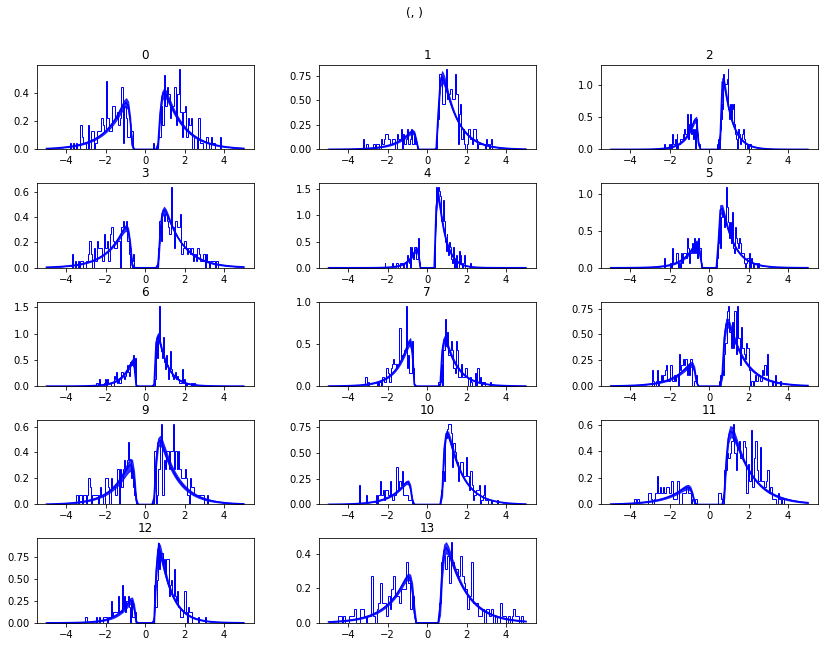

In [18]:
models_1_par[0].plot_posterior_predictive(figsize=(14, 10))

In [19]:
m_comb = kabuki.utils.concat_models(models_1_par)  # combine four chains together

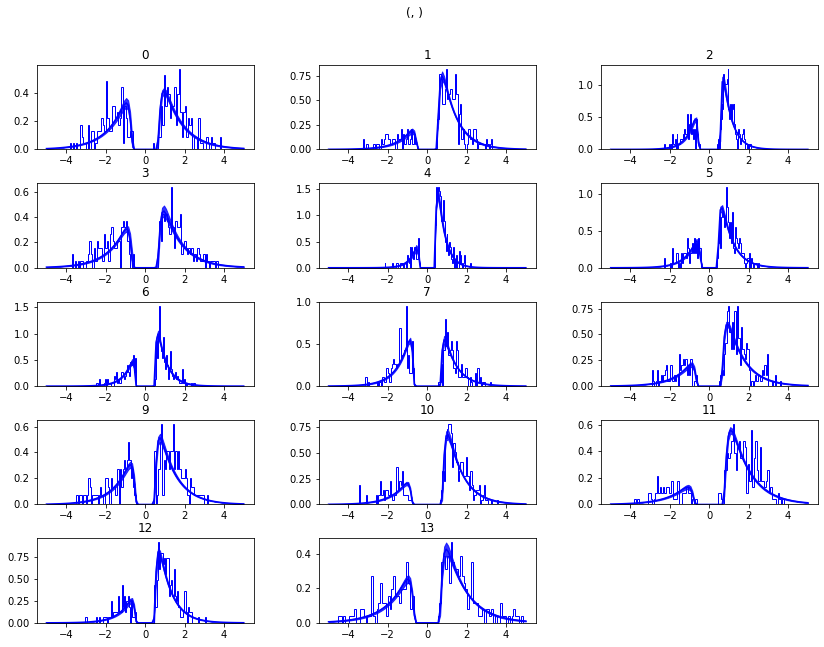

In [20]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

### Model 2: `v` depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [21]:
def ms2(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m2"):
    print("running model%i" % id)

    import hddm

    dbname = save_name + "_chain_%i.db" % id
    mname = save_name + "_chain_%i" % id

    m = hddm.HDDM(data, depends_on={"v": "stim"})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db="pickle")  # save the model data
    m.save(mname)

    return m

In [22]:
%%time
# note: the samples, burn, and chains can be changed too
models_2 = p_map(partial(ms2, data=data, samples=samples, burn=burn), range(chains))

  0%|          | 0/5 [00:00<?, ?it/s]

running model0
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model1
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model2
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model4
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 5000 complete in 0.5 sec[                  0%                  ] 6 of 5000 complete in 0.5 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 16 of 5000 complete in 1.6 sec[                  0%                  ] 16 of 5000 complete in 1.7 sec[                  0%                  ] 16 of 5000 complete in 1.6 sec[                  0%                  ] 16 of 5000 complete in 1.6 sec[         

 [                  2%                  ] 121 of 5000 complete in 13.1 sec[                  2%                  ] 121 of 5000 complete in 13.2 sec[                  2%                  ] 120 of 5000 complete in 13.4 sec[                  2%                  ] 121 of 5000 complete in 13.4 sec[                  2%                  ] 121 of 5000 complete in 13.4 sec[                  2%                  ] 126 of 5000 complete in 13.6 sec[                  2%                  ] 126 of 5000 complete in 13.8 sec[                  2%                  ] 125 of 5000 complete in 13.9 sec[                  2%                  ] 126 of 5000 complete in 13.9 sec[                  2%                  ] 126 of 5000 complete in 14.0 sec[                  2%                  ] 131 of 5000 complete in 14.1 sec[                  2%                  ] 131 of 5000 complete in 14.3 sec[                  2%                  ] 130 of 5000 complete in 14.4 sec[                  2%                  ] 131 of 50

 [-                 4%                  ] 231 of 5000 complete in 25.4 sec[-                 4%                  ] 236 of 5000 complete in 25.7 sec[-                 4%                  ] 231 of 5000 complete in 25.8 sec[-                 4%                  ] 236 of 5000 complete in 26.0 sec[-                 4%                  ] 235 of 5000 complete in 26.0 sec[-                 4%                  ] 236 of 5000 complete in 26.0 sec[-                 4%                  ] 241 of 5000 complete in 26.3 sec[-                 4%                  ] 236 of 5000 complete in 26.4 sec[-                 4%                  ] 241 of 5000 complete in 26.6 sec[-                 4%                  ] 240 of 5000 complete in 26.6 sec[-                 4%                  ] 241 of 5000 complete in 26.5 sec[-                 4%                  ] 246 of 5000 complete in 26.8 sec[-                 4%                  ] 241 of 5000 complete in 27.0 sec[-                 4%                  ] 246 of 50

 [--                6%                  ] 345 of 5000 complete in 38.2 sec[--                6%                  ] 346 of 5000 complete in 38.3 sec[--                6%                  ] 346 of 5000 complete in 38.2 sec[--                7%                  ] 351 of 5000 complete in 38.5 sec[--                6%                  ] 346 of 5000 complete in 38.6 sec[--                7%                  ] 350 of 5000 complete in 38.8 sec[--                7%                  ] 351 of 5000 complete in 38.8 sec[--                7%                  ] 351 of 5000 complete in 38.8 sec[--                7%                  ] 356 of 5000 complete in 39.0 sec[--                7%                  ] 351 of 5000 complete in 39.2 sec[--                7%                  ] 355 of 5000 complete in 39.4 sec[--                7%                  ] 356 of 5000 complete in 39.4 sec[--                7%                  ] 356 of 5000 complete in 39.3 sec[--                7%                  ] 361 of 50

 ---               9%                  ] 470 of 5000 complete in 51.9 secc[---               9%                  ] 456 of 5000 complete in 50.8 sec[---               9%                  ] 456 of 5000 complete in 50.7 sec[---               9%                  ] 461 of 5000 complete in 51.0 sec[---               9%                  ] 466 of 5000 complete in 51.1 sec[---               9%                  ] 465 of 5000 complete in 51.3 sec[---               9%                  ] 461 of 5000 complete in 51.3 sec[---               9%                  ] 461 of 5000 complete in 51.3 sec[---               9%                  ] 466 of 5000 complete in 51.5 sec[---               9%                  ] 471 of 5000 complete in 51.6 sec [---               9%                  ] 466 of 5000 complete in 51.9 sec[---               9%                  ] 466 of 5000 complete in 51.9 sec[---               9%                  ] 471 of 5000 complete in 52.1 sec[---               9%                  ] 476 of 5

 [----             11%                  ] 576 of 5000 complete in 63.4 sec[----             11%                  ] 571 of 5000 complete in 63.5 sec[----             11%                  ] 575 of 5000 complete in 63.6 sec[----             11%                  ] 571 of 5000 complete in 63.5 sec[----             11%                  ] 576 of 5000 complete in 63.8 sec[----             11%                  ] 581 of 5000 complete in 64.0 sec[----             11%                  ] 576 of 5000 complete in 64.1 sec[----             11%                  ] 580 of 5000 complete in 64.1 sec[----             11%                  ] 576 of 5000 complete in 64.1 sec[----             11%                  ] 581 of 5000 complete in 64.3 sec[----             11%                  ] 586 of 5000 complete in 64.6 sec[----             11%                  ] 581 of 5000 complete in 64.6 sec[----             11%                  ] 585 of 5000 complete in 64.7 sec[----             11%                  ] 581 of 50

 [-----            13%                  ] 686 of 5000 complete in 75.7 sec[-----            13%                  ] 681 of 5000 complete in 75.8 sec[-----            13%                  ] 685 of 5000 complete in 76.0 sec[-----            13%                  ] 691 of 5000 complete in 76.1 sec[-----            13%                  ] 689 of 5000 complete in 76.2 sec[-----            13%                  ] 691 of 5000 complete in 76.3 sec[-----            13%                  ] 686 of 5000 complete in 76.4 sec[-----            13%                  ] 690 of 5000 complete in 76.6 sec[-----            13%                  ] 696 of 5000 complete in 76.7 sec[-----            13%                  ] 694 of 5000 complete in 76.7 sec[-----            13%                  ] 696 of 5000 complete in 76.8 sec[-----            13%                  ] 691 of 5000 complete in 76.9 sec[-----            13%                  ] 695 of 5000 complete in 77.1 sec[-----            14%                  ] 701 of 50

 [------           15%                  ] 795 of 5000 complete in 88.2 sec[------           15%                  ] 796 of 5000 complete in 88.5 sec[------           15%                  ] 799 of 5000 complete in 88.6 sec[------           16%                  ] 800 of 5000 complete in 88.8 sec[------           16%                  ] 800 of 5000 complete in 88.7 sec[------           16%                  ] 806 of 5000 complete in 88.8 sec[------           16%                  ] 801 of 5000 complete in 89.1 sec[------           16%                  ] 804 of 5000 complete in 89.2 sec[------           16%                  ] 805 of 5000 complete in 89.3 sec[------           16%                  ] 805 of 5000 complete in 89.2 sec[------           16%                  ] 811 of 5000 complete in 89.3 sec[------           16%                  ] 806 of 5000 complete in 89.7 sec[------           16%                  ] 809 of 5000 complete in 89.7 sec[------           16%                  ] 810 of 50

 [------           18%                  ] 916 of 5000 complete in 100.9 sec[------           18%                  ] 906 of 5000 complete in 100.9 sec[------           18%                  ] 910 of 5000 complete in 100.9 sec[------           18%                  ] 914 of 5000 complete in 101.3 sec[------           18%                  ] 915 of 5000 complete in 101.4 sec[------           18%                  ] 911 of 5000 complete in 101.4 sec[------           18%                  ] 921 of 5000 complete in 101.5 sec[------           18%                  ] 915 of 5000 complete in 101.4 sec[------           18%                  ] 919 of 5000 complete in 101.9 sec[------           18%                  ] 920 of 5000 complete in 101.9 sec[------           18%                  ] 916 of 5000 complete in 102.0 sec[-------          18%                  ] 926 of 5000 complete in 102.0 sec[------           18%                  ] 920 of 5000 complete in 102.0 sec[-------          18%                

 --------         22%                  ] 1126 of 5000 complete in 124.5 secc[-------          20%                  ] 1026 of 5000 complete in 113.2 sec[-------          20%                  ] 1025 of 5000 complete in 113.5 sec[-------          20%                  ] 1024 of 5000 complete in 113.5 sec[-------          20%                  ] 1021 of 5000 complete in 113.6 sec[-------          20%                  ] 1025 of 5000 complete in 113.6 sec[-------          20%                  ] 1031 of 5000 complete in 113.8 sec[-------          20%                  ] 1030 of 5000 complete in 114.0 sec[-------          20%                  ] 1029 of 5000 complete in 114.1 sec[-------          20%                  ] 1026 of 5000 complete in 114.1 sec[-------          20%                  ] 1030 of 5000 complete in 114.2 sec[-------          20%                  ] 1036 of 5000 complete in 114.4 sec[-------          20%                  ] 1035 of 5000 complete in 114.6 sec[-------          20%   

 --------         23%                  ] 1166 of 5000 complete in 129.0 secc[--------         22%                  ] 1130 of 5000 complete in 125.6 sec[--------         22%                  ] 1136 of 5000 complete in 125.7 sec[--------         22%                  ] 1135 of 5000 complete in 125.8 sec[--------         22%                  ] 1134 of 5000 complete in 125.9 sec[--------         22%                  ] 1140 of 5000 complete in 126.0 sec[--------         22%                  ] 1135 of 5000 complete in 126.2 sec[--------         22%                  ] 1141 of 5000 complete in 126.2 sec[--------         22%                  ] 1140 of 5000 complete in 126.3 sec[--------         22%                  ] 1139 of 5000 complete in 126.4 sec[--------         22%                  ] 1145 of 5000 complete in 126.5 sec [--------         22%                  ] 1146 of 5000 complete in 126.8 sec[--------         22%                  ] 1144 of 5000 complete in 127.0 sec[--------         22%  

 [---------        24%                  ] 1240 of 5000 complete in 137.9 sec[---------        24%                  ] 1245 of 5000 complete in 137.9 sec[---------        25%                  ] 1250 of 5000 complete in 138.0 sec[---------        24%                  ] 1244 of 5000 complete in 138.3 sec[---------        25%                  ] 1251 of 5000 complete in 138.3 sec[---------        24%                  ] 1245 of 5000 complete in 138.4 sec[---------        25%                  ] 1250 of 5000 complete in 138.4 sec[---------        25%                  ] 1255 of 5000 complete in 138.5 sec[---------        24%                  ] 1249 of 5000 complete in 138.8 sec[---------        25%                  ] 1256 of 5000 complete in 138.9 sec[---------        25%                  ] 1250 of 5000 complete in 139.0 sec[---------        25%                  ] 1255 of 5000 complete in 138.9 sec[---------        25%                  ] 1260 of 5000 complete in 139.0 sec[---------        25%   

 ----------       28%                  ] 1425 of 5000 complete in 157.4 secc[----------       27%                  ] 1360 of 5000 complete in 150.2 sec[----------       26%                  ] 1349 of 5000 complete in 150.1 sec[----------       27%                  ] 1354 of 5000 complete in 150.3 sec[----------       27%                  ] 1360 of 5000 complete in 150.3 sec[----------       27%                  ] 1361 of 5000 complete in 150.5 sec[----------       27%                  ] 1354 of 5000 complete in 150.7 sec[----------       27%                  ] 1365 of 5000 complete in 150.7 sec[----------       27%                  ] 1359 of 5000 complete in 150.8 sec[----------       27%                  ] 1365 of 5000 complete in 150.8 sec[----------       27%                  ] 1366 of 5000 complete in 151.0 sec[----------       27%                  ] 1359 of 5000 complete in 151.2 sec[----------       27%                  ] 1370 of 5000 complete in 151.3 sec[----------       27%   

 [-----------      29%                  ] 1470 of 5000 complete in 162.3 sec[-----------      29%                  ] 1459 of 5000 complete in 162.4 sec[-----------      29%                  ] 1470 of 5000 complete in 162.4 sec[-----------      29%                  ] 1464 of 5000 complete in 162.5 sec[-----------      29%                  ] 1471 of 5000 complete in 162.5 sec[-----------      29%                  ] 1475 of 5000 complete in 162.8 sec[-----------      29%                  ] 1464 of 5000 complete in 163.0 sec[-----------      29%                  ] 1475 of 5000 complete in 162.9 sec[-----------      29%                  ] 1469 of 5000 complete in 163.0 sec[-----------      29%                  ] 1476 of 5000 complete in 163.1 sec[-----------      29%                  ] 1480 of 5000 complete in 163.3 sec[-----------      29%                  ] 1469 of 5000 complete in 163.5 sec[-----------      29%                  ] 1480 of 5000 complete in 163.5 sec[-----------      29%   

 [------------     31%                  ] 1580 of 5000 complete in 174.2 sec[-----------      31%                  ] 1569 of 5000 complete in 174.5 sec[------------     31%                  ] 1581 of 5000 complete in 174.5 sec[-----------      31%                  ] 1574 of 5000 complete in 174.6 sec[------------     31%                  ] 1580 of 5000 complete in 174.6 sec[------------     31%                  ] 1585 of 5000 complete in 174.7 sec[------------     31%                  ] 1586 of 5000 complete in 175.0 sec[-----------      31%                  ] 1574 of 5000 complete in 175.0 sec[------------     31%                  ] 1579 of 5000 complete in 175.1 sec[------------     31%                  ] 1585 of 5000 complete in 175.2 sec[------------     31%                  ] 1590 of 5000 complete in 175.3 sec[------------     31%                  ] 1579 of 5000 complete in 175.6 sec[------------     31%                  ] 1591 of 5000 complete in 175.6 sec[------------     31%   

 [------------     33%                  ] 1685 of 5000 complete in 186.3 sec[------------     33%                  ] 1679 of 5000 complete in 186.6 sec[------------     33%                  ] 1691 of 5000 complete in 186.6 sec[------------     33%                  ] 1695 of 5000 complete in 186.9 sec [------------     33%                  ] 1684 of 5000 complete in 186.9 sec [------------     33%                  ] 1690 of 5000 complete in 186.8 sec[------------     33%                  ] 1696 of 5000 complete in 187.2 sec[------------     33%                  ] 1684 of 5000 complete in 187.2 sec[------------     34%                  ] 1700 of 5000 complete in 187.4 sec  [------------     33%                  ] 1695 of 5000 complete in 187.4 sec[------------     33%                  ] 1689 of 5000 complete in 187.4 sec[------------     34%                  ] 1701 of 5000 complete in 187.7 sec[------------     33%                  ] 1689 of 5000 complete in 187.8 sec[------------     34

 [-------------    35%                  ] 1795 of 5000 complete in 198.5 sec[-------------    35%                  ] 1789 of 5000 complete in 198.7 sec[-------------    36%                  ] 1801 of 5000 complete in 198.8 sec[-------------    36%                  ] 1805 of 5000 complete in 199.0 sec[-------------    35%                  ] 1794 of 5000 complete in 199.0 sec[-------------    36%                  ] 1800 of 5000 complete in 199.0 sec[-------------    35%                  ] 1794 of 5000 complete in 199.2 sec[-------------    36%                  ] 1806 of 5000 complete in 199.4 sec[-------------    36%                  ] 1810 of 5000 complete in 199.5 sec[-------------    35%                  ] 1799 of 5000 complete in 199.5 sec[-------------    36%                  ] 1805 of 5000 complete in 199.5 sec[-------------    35%                  ] 1799 of 5000 complete in 199.8 sec[-------------    36%                  ] 1810 of 5000 complete in 199.9 sec[-------------    36%   

 --------------   38%                  ] 1945 of 5000 complete in 214.8 secc[--------------   38%                  ] 1910 of 5000 complete in 210.8 sec[--------------   37%                  ] 1899 of 5000 complete in 210.9 sec[--------------   38%                  ] 1915 of 5000 complete in 211.0 sec[--------------   38%                  ] 1904 of 5000 complete in 211.0 sec[--------------   38%                  ] 1909 of 5000 complete in 211.2 sec[--------------   38%                  ] 1915 of 5000 complete in 211.4 sec[--------------   38%                  ] 1920 of 5000 complete in 211.5 sec[--------------   38%                  ] 1904 of 5000 complete in 211.5 sec[--------------   38%                  ] 1909 of 5000 complete in 211.6 sec[--------------   38%                  ] 1914 of 5000 complete in 211.8 sec[--------------   38%                  ] 1920 of 5000 complete in 212.0 sec[--------------   38%                  ] 1925 of 5000 complete in 212.1 sec[--------------   38%   

 [---------------  40%                  ] 2009 of 5000 complete in 223.0 sec[---------------  40%                  ] 2025 of 5000 complete in 223.1 sec[---------------  40%                  ] 2020 of 5000 complete in 223.1 sec[---------------  40%                  ] 2014 of 5000 complete in 223.3 sec[---------------  40%                  ] 2019 of 5000 complete in 223.5 sec[---------------  40%                  ] 2014 of 5000 complete in 223.6 sec[---------------  40%                  ] 2030 of 5000 complete in 223.7 sec[---------------  40%                  ] 2025 of 5000 complete in 223.7 sec[---------------  40%                  ] 2019 of 5000 complete in 223.8 sec[---------------  40%                  ] 2019 of 5000 complete in 224.1 sec[---------------  40%                  ] 2024 of 5000 complete in 224.1 sec[---------------  40%                  ] 2035 of 5000 complete in 224.2 sec[---------------  40%                  ] 2030 of 5000 complete in 224.2 sec[---------------  40%   

 [---------------- 42%                  ] 2119 of 5000 complete in 235.2 sec[---------------- 42%                  ] 2124 of 5000 complete in 235.2 sec[---------------- 42%                  ] 2135 of 5000 complete in 235.3 sec[---------------- 42%                  ] 2124 of 5000 complete in 235.4 sec[---------------- 42%                  ] 2135 of 5000 complete in 235.7 sec[---------------- 42%                  ] 2124 of 5000 complete in 235.8 sec[---------------- 42%                  ] 2129 of 5000 complete in 235.7 sec[---------------- 42%                  ] 2140 of 5000 complete in 235.9 sec[---------------- 42%                  ] 2129 of 5000 complete in 236.0 sec[---------------- 42%                  ] 2140 of 5000 complete in 236.3 sec[---------------- 42%                  ] 2129 of 5000 complete in 236.3 sec[---------------- 42%                  ] 2134 of 5000 complete in 236.3 sec[---------------- 42%                  ] 2145 of 5000 complete in 236.4 sec[---------------- 42%   

 [-----------------44%                  ] 2245 of 5000 complete in 247.4 sec[---------------- 44%                  ] 2229 of 5000 complete in 247.4 sec[---------------- 44%                  ] 2234 of 5000 complete in 247.5 sec[---------------- 44%                  ] 2234 of 5000 complete in 247.7 sec[-----------------44%                  ] 2245 of 5000 complete in 247.8 sec[-----------------45%                  ] 2250 of 5000 complete in 247.9 sec[---------------- 44%                  ] 2234 of 5000 complete in 247.9 sec[-----------------44%                  ] 2239 of 5000 complete in 248.1 sec[-----------------44%                  ] 2239 of 5000 complete in 248.2 sec[-----------------45%                  ] 2250 of 5000 complete in 248.4 sec[-----------------45%                  ] 2255 of 5000 complete in 248.5 sec[-----------------44%                  ] 2239 of 5000 complete in 248.5 sec[-----------------44%                  ] 2244 of 5000 complete in 248.6 sec[-----------------44%   

 [-----------------46%                  ] 2339 of 5000 complete in 259.5 sec[-----------------47%                  ] 2350 of 5000 complete in 259.7 sec[-----------------46%                  ] 2344 of 5000 complete in 259.7 sec[-----------------46%                  ] 2344 of 5000 complete in 259.8 sec[-----------------47%                  ] 2360 of 5000 complete in 259.9 sec[-----------------46%                  ] 2344 of 5000 complete in 260.0 sec[-----------------47%                  ] 2355 of 5000 complete in 260.2 sec[-----------------46%                  ] 2349 of 5000 complete in 260.3 sec[-----------------46%                  ] 2349 of 5000 complete in 260.4 sec[-----------------47%                  ] 2365 of 5000 complete in 260.5 sec[-----------------46%                  ] 2349 of 5000 complete in 260.6 sec[-----------------47%                  ] 2360 of 5000 complete in 260.8 sec[-----------------47%                  ] 2354 of 5000 complete in 260.9 sec[-----------------47%   

 -----------------50%                  ] 2539 of 5000 complete in 281.1 secc[-----------------48%                  ] 2449 of 5000 complete in 271.8 sec[-----------------49%                  ] 2470 of 5000 complete in 271.9 sec[-----------------49%                  ] 2460 of 5000 complete in 272.0 sec[-----------------49%                  ] 2454 of 5000 complete in 272.0 sec[-----------------49%                  ] 2459 of 5000 complete in 272.2 sec[-----------------49%                  ] 2454 of 5000 complete in 272.3 sec[-----------------49%                  ] 2475 of 5000 complete in 272.5 sec[-----------------49%                  ] 2465 of 5000 complete in 272.5 sec[-----------------49%                  ] 2459 of 5000 complete in 272.5 sec[-----------------49%                  ] 2464 of 5000 complete in 272.7 sec[-----------------49%                  ] 2459 of 5000 complete in 272.9 sec[-----------------49%                  ] 2480 of 5000 complete in 273.0 sec[-----------------49%   

 -----------------52%                  ] 2629 of 5000 complete in 291.2 sec [-----------------51%                  ] 2564 of 5000 complete in 284.1 sec[-----------------51%                  ] 2559 of 5000 complete in 284.1 sec[-----------------51%                  ] 2569 of 5000 complete in 284.4 sec[-----------------51%                  ] 2585 of 5000 complete in 284.6 sec[-----------------51%                  ] 2569 of 5000 complete in 284.6 sec[-----------------51%                  ] 2575 of 5000 complete in 284.6 sec[-----------------51%                  ] 2564 of 5000 complete in 284.7 sec[-----------------51%                  ] 2574 of 5000 complete in 284.9 sec[-----------------51%                  ] 2590 of 5000 complete in 285.1 sec[-----------------51%                  ] 2574 of 5000 complete in 285.2 sec[-----------------51%                  ] 2580 of 5000 complete in 285.2 sec[-----------------51%                  ] 2569 of 5000 complete in 285.3 sec[-----------------51%   

 [-----------------53%                  ] 2690 of 5000 complete in 296.3 sec[-----------------53%                  ] 2669 of 5000 complete in 296.3 sec[-----------------53%                  ] 2679 of 5000 complete in 296.6 sec[-----------------53%                  ] 2685 of 5000 complete in 296.7 sec[-----------------53%                  ] 2679 of 5000 complete in 296.7 sec[-----------------53%                  ] 2695 of 5000 complete in 296.8 sec[-----------------53%                  ] 2674 of 5000 complete in 296.9 sec[-----------------53%                  ] 2684 of 5000 complete in 297.2 sec[-----------------53%                  ] 2690 of 5000 complete in 297.2 sec[-----------------53%                  ] 2684 of 5000 complete in 297.2 sec[-----------------54%                  ] 2700 of 5000 complete in 297.4 sec[-----------------53%                  ] 2679 of 5000 complete in 297.4 sec[-----------------53%                  ] 2689 of 5000 complete in 297.7 sec[-----------------53%   

 [-----------------55%-                 ] 2779 of 5000 complete in 308.5 sec[-----------------56%-                 ] 2800 of 5000 complete in 308.6 sec[-----------------55%-                 ] 2795 of 5000 complete in 308.6 sec[-----------------55%-                 ] 2789 of 5000 complete in 308.8 sec[-----------------55%-                 ] 2789 of 5000 complete in 308.8 sec[-----------------55%-                 ] 2784 of 5000 complete in 309.1 sec[-----------------56%-                 ] 2805 of 5000 complete in 309.1 sec[-----------------56%-                 ] 2800 of 5000 complete in 309.2 sec[-----------------55%-                 ] 2794 of 5000 complete in 309.3 sec[-----------------55%-                 ] 2794 of 5000 complete in 309.3 sec[-----------------55%-                 ] 2789 of 5000 complete in 309.6 sec[-----------------56%-                 ] 2810 of 5000 complete in 309.7 sec[-----------------56%-                 ] 2805 of 5000 complete in 309.7 sec[-----------------55%-  

 [-----------------58%--                ] 2910 of 5000 complete in 320.7 sec[-----------------57%-                 ] 2889 of 5000 complete in 320.7 sec[-----------------58%--                ] 2905 of 5000 complete in 320.7 sec[-----------------57%--                ] 2899 of 5000 complete in 320.9 sec[-----------------57%--                ] 2899 of 5000 complete in 321.1 sec[-----------------58%--                ] 2915 of 5000 complete in 321.2 sec[-----------------58%--                ] 2910 of 5000 complete in 321.2 sec[-----------------57%-                 ] 2894 of 5000 complete in 321.3 sec[-----------------58%--                ] 2904 of 5000 complete in 321.5 sec[-----------------58%--                ] 2904 of 5000 complete in 321.6 sec[-----------------58%--                ] 2920 of 5000 complete in 321.8 sec[-----------------58%--                ] 2915 of 5000 complete in 321.8 sec[-----------------57%--                ] 2899 of 5000 complete in 321.9 sec[-----------------58%-- 

 [-----------------60%--                ] 3015 of 5000 complete in 332.8 sec[-----------------60%--                ] 3020 of 5000 complete in 332.9 sec[-----------------59%--                ] 2998 of 5000 complete in 332.9 sec[-----------------60%--                ] 3009 of 5000 complete in 333.2 sec[-----------------60%--                ] 3009 of 5000 complete in 333.2 sec[-----------------60%--                ] 3020 of 5000 complete in 333.3 sec[-----------------60%--                ] 3025 of 5000 complete in 333.4 sec[-----------------60%--                ] 3003 of 5000 complete in 333.4 sec[-----------------60%--                ] 3014 of 5000 complete in 333.7 sec[-----------------60%--                ] 3014 of 5000 complete in 333.8 sec[-----------------60%--                ] 3025 of 5000 complete in 333.9 sec[-----------------60%---               ] 3030 of 5000 complete in 334.0 sec[-----------------60%--                ] 3008 of 5000 complete in 334.0 sec[-----------------60%-- 

 [-----------------62%---               ] 3103 of 5000 complete in 344.9 sec[-----------------62%---               ] 3114 of 5000 complete in 345.0 sec[-----------------62%---               ] 3119 of 5000 complete in 345.2 sec[-----------------62%---               ] 3130 of 5000 complete in 345.4 sec[-----------------62%---               ] 3135 of 5000 complete in 345.4 sec[-----------------62%---               ] 3108 of 5000 complete in 345.4 sec[-----------------62%---               ] 3119 of 5000 complete in 345.6 sec[-----------------62%---               ] 3124 of 5000 complete in 345.7 sec[-----------------62%---               ] 3135 of 5000 complete in 345.9 sec[-----------------62%---               ] 3140 of 5000 complete in 346.0 sec[-----------------62%---               ] 3113 of 5000 complete in 346.0 sec[-----------------62%---               ] 3124 of 5000 complete in 346.2 sec[-----------------62%---               ] 3129 of 5000 complete in 346.3 sec[-----------------62%---

 [-----------------64%----              ] 3224 of 5000 complete in 357.0 sec[-----------------64%----              ] 3245 of 5000 complete in 357.4 sec[-----------------64%----              ] 3224 of 5000 complete in 357.4 sec[-----------------64%----              ] 3218 of 5000 complete in 357.5 sec[-----------------64%----              ] 3240 of 5000 complete in 357.6 sec[-----------------64%----              ] 3229 of 5000 complete in 357.5 sec[-----------------64%----              ] 3229 of 5000 complete in 357.9 sec[-----------------65%----              ] 3250 of 5000 complete in 358.0 sec[-----------------64%----              ] 3223 of 5000 complete in 358.0 sec[-----------------64%----              ] 3245 of 5000 complete in 358.1 sec[-----------------64%----              ] 3234 of 5000 complete in 358.0 sec[-----------------64%----              ] 3234 of 5000 complete in 358.5 sec[-----------------65%----              ] 3255 of 5000 complete in 358.5 sec[-----------------64%---

 -----------------66%-----             ] 3344 of 5000 complete in 370.1 secc[-----------------67%-----             ] 3355 of 5000 complete in 369.5 sec  [-----------------67%-----             ] 3350 of 5000 complete in 369.6 sec[-----------------66%-----             ] 3327 of 5000 complete in 369.6 sec[-----------------66%-----             ] 3333 of 5000 complete in 369.6 sec[-----------------66%-----             ] 3339 of 5000 complete in 369.6 sec[-----------------67%-----             ] 3360 of 5000 complete in 370.0 sec[-----------------66%-----             ] 3332 of 5000 complete in 370.1 sec[-----------------67%-----             ] 3355 of 5000 complete in 370.2 sec [-----------------66%-----             ] 3338 of 5000 complete in 370.2 sec[-----------------67%-----             ] 3365 of 5000 complete in 370.6 sec  [-----------------66%-----             ] 3349 of 5000 complete in 370.6 sec[-----------------66%-----             ] 3337 of 5000 complete in 370.7 sec[-----------------6

[-----------------71%-------           ] 3575 of 5000 complete in 393.7 secc[-----------------69%------            ] 3465 of 5000 complete in 381.6 sec[-----------------68%------            ] 3443 of 5000 complete in 381.8 sec[-----------------69%------            ] 3460 of 5000 complete in 381.8 sec[-----------------68%------            ] 3437 of 5000 complete in 382.0 sec[-----------------69%------            ] 3454 of 5000 complete in 381.9 sec[-----------------69%------            ] 3470 of 5000 complete in 382.1 sec[-----------------68%------            ] 3448 of 5000 complete in 382.3 sec[-----------------69%------            ] 3465 of 5000 complete in 382.3 sec[-----------------68%------            ] 3442 of 5000 complete in 382.5 sec[-----------------69%------            ] 3459 of 5000 complete in 382.5 sec[-----------------69%------            ] 3475 of 5000 complete in 382.7 sec[-----------------69%------            ] 3453 of 5000 complete in 382.8 sec[-----------------69%---

 [-----------------71%-------           ] 3559 of 5000 complete in 393.6 sec[-----------------71%-------           ] 3553 of 5000 complete in 393.8 sec[-----------------71%-------           ] 3570 of 5000 complete in 393.9 sec[-----------------71%-------           ] 3580 of 5000 complete in 394.2 sec[-----------------70%------            ] 3547 of 5000 complete in 394.2 sec[-----------------71%-------           ] 3564 of 5000 complete in 394.1 sec[-----------------71%-------           ] 3558 of 5000 complete in 394.3 sec[-----------------71%-------           ] 3575 of 5000 complete in 394.5 sec  [-----------------71%-------           ] 3585 of 5000 complete in 394.7 sec[-----------------71%-------           ] 3569 of 5000 complete in 394.7 sec[-----------------71%------            ] 3552 of 5000 complete in 394.8 sec[-----------------71%-------           ] 3563 of 5000 complete in 394.9 sec[-----------------71%-------           ] 3580 of 5000 complete in 395.0 sec[-----------------71%-

 [-----------------73%-------           ] 3680 of 5000 complete in 405.8 sec[-----------------73%-------           ] 3663 of 5000 complete in 405.9 sec[-----------------73%-------           ] 3651 of 5000 complete in 406.0 sec[-----------------73%--------          ] 3690 of 5000 complete in 406.2 sec[-----------------73%-------           ] 3674 of 5000 complete in 406.2 sec[-----------------73%--------          ] 3685 of 5000 complete in 406.4 sec[-----------------73%-------           ] 3656 of 5000 complete in 406.5 sec[-----------------73%-------           ] 3668 of 5000 complete in 406.5 sec[-----------------73%--------          ] 3695 of 5000 complete in 406.7 sec[-----------------73%-------           ] 3679 of 5000 complete in 406.8 sec[-----------------73%--------          ] 3690 of 5000 complete in 406.9 sec[-----------------73%-------           ] 3661 of 5000 complete in 407.1 sec[-----------------73%-------           ] 3673 of 5000 complete in 407.1 sec[-----------------74%---

 [-----------------75%--------          ] 3790 of 5000 complete in 418.0 sec[-----------------75%--------          ] 3779 of 5000 complete in 418.0 sec[-----------------75%--------          ] 3761 of 5000 complete in 418.1 sec[-----------------76%--------          ] 3800 of 5000 complete in 418.5 sec[-----------------75%--------          ] 3778 of 5000 complete in 418.5 sec[-----------------75%--------          ] 3795 of 5000 complete in 418.5 sec[-----------------75%--------          ] 3784 of 5000 complete in 418.5 sec[-----------------75%--------          ] 3766 of 5000 complete in 418.7 sec[-----------------76%--------          ] 3805 of 5000 complete in 419.0 sec[-----------------75%--------          ] 3783 of 5000 complete in 419.0 sec[-----------------76%--------          ] 3800 of 5000 complete in 419.1 sec[-----------------75%--------          ] 3789 of 5000 complete in 419.1 sec[-----------------75%--------          ] 3771 of 5000 complete in 419.2 sec[-----------------76%---

 [-----------------77%---------         ] 3889 of 5000 complete in 430.1 sec[-----------------77%---------         ] 3871 of 5000 complete in 430.2 sec[-----------------78%---------         ] 3905 of 5000 complete in 430.3 sec[-----------------78%---------         ] 3905 of 5000 complete in 430.5 sec[-----------------77%---------         ] 3888 of 5000 complete in 430.6 sec  [-----------------77%---------         ] 3876 of 5000 complete in 430.7 sec[-----------------77%---------         ] 3894 of 5000 complete in 430.7 sec[-----------------78%---------         ] 3910 of 5000 complete in 430.8 sec[-----------------78%---------         ] 3910 of 5000 complete in 431.1 sec[-----------------77%---------         ] 3893 of 5000 complete in 431.2 sec[-----------------77%---------         ] 3881 of 5000 complete in 431.3 sec[-----------------77%---------         ] 3899 of 5000 complete in 431.3 sec[-----------------78%---------         ] 3915 of 5000 complete in 431.4 sec[-----------------78%-

 [-----------------79%----------        ] 3981 of 5000 complete in 442.2 sec[-----------------80%----------        ] 4015 of 5000 complete in 442.3 sec[-----------------80%----------        ] 4015 of 5000 complete in 442.6 sec[-----------------79%----------        ] 3998 of 5000 complete in 442.6 sec[-----------------79%----------        ] 3998 of 5000 complete in 442.6 sec[-----------------79%----------        ] 3986 of 5000 complete in 442.7 sec[-----------------80%----------        ] 4020 of 5000 complete in 442.9 sec[-----------------80%----------        ] 4003 of 5000 complete in 443.1 sec[-----------------80%----------        ] 4020 of 5000 complete in 443.2 sec[-----------------80%----------        ] 4003 of 5000 complete in 443.2 sec[-----------------79%----------        ] 3991 of 5000 complete in 443.3 sec[-----------------80%----------        ] 4025 of 5000 complete in 443.4 sec[-----------------80%----------        ] 4008 of 5000 complete in 443.7 sec[-----------------80%---

 -----------------84%------------      ] 4225 of 5000 complete in 466.1 secc[-----------------82%-----------       ] 4124 of 5000 complete in 454.6 sec[-----------------82%-----------       ] 4108 of 5000 complete in 454.6 sec[-----------------82%-----------       ] 4108 of 5000 complete in 454.8 sec[-----------------82%-----------       ] 4125 of 5000 complete in 454.8 sec[-----------------81%-----------       ] 4096 of 5000 complete in 455.1 sec[-----------------82%-----------       ] 4129 of 5000 complete in 455.2 sec[-----------------82%-----------       ] 4113 of 5000 complete in 455.1 sec[-----------------82%-----------       ] 4113 of 5000 complete in 455.3 sec[-----------------82%-----------       ] 4130 of 5000 complete in 455.4 sec[-----------------82%-----------       ] 4101 of 5000 complete in 455.6 sec[-----------------82%-----------       ] 4134 of 5000 complete in 455.7 sec[-----------------82%-----------       ] 4118 of 5000 complete in 455.7 sec[-----------------82%---

 [-----------------84%------------      ] 4234 of 5000 complete in 466.7 sec[-----------------84%------------      ] 4218 of 5000 complete in 467.1 sec[-----------------84%-----------       ] 4206 of 5000 complete in 467.1 sec[-----------------84%------------      ] 4222 of 5000 complete in 467.1 sec[-----------------84%------------      ] 4235 of 5000 complete in 467.2 sec[-----------------84%------------      ] 4239 of 5000 complete in 467.2 sec[-----------------84%------------      ] 4223 of 5000 complete in 467.7 sec[-----------------84%------------      ] 4211 of 5000 complete in 467.7 sec[-----------------84%------------      ] 4227 of 5000 complete in 467.6 sec[-----------------84%------------      ] 4240 of 5000 complete in 467.8 sec[-----------------84%------------      ] 4244 of 5000 complete in 467.8 sec[-----------------84%------------      ] 4228 of 5000 complete in 468.2 sec[-----------------84%------------      ] 4216 of 5000 complete in 468.2 sec[-----------------84%---

 [-----------------86%------------      ] 4326 of 5000 complete in 479.0 sec[-----------------86%-------------     ] 4349 of 5000 complete in 479.2 sec[-----------------86%------------      ] 4328 of 5000 complete in 479.2 sec[-----------------86%------------      ] 4316 of 5000 complete in 479.3 sec[-----------------86%-------------     ] 4345 of 5000 complete in 479.4 sec[-----------------86%------------      ] 4331 of 5000 complete in 479.6 sec[-----------------87%-------------     ] 4354 of 5000 complete in 479.7 sec[-----------------86%------------      ] 4333 of 5000 complete in 479.8 sec[-----------------86%------------      ] 4321 of 5000 complete in 479.8 sec[-----------------87%-------------     ] 4350 of 5000 complete in 480.0 sec[-----------------86%------------      ] 4336 of 5000 complete in 480.1 sec[-----------------87%-------------     ] 4359 of 5000 complete in 480.3 sec[-----------------86%------------      ] 4338 of 5000 complete in 480.3 sec[-----------------86%---

 [-----------------89%-------------     ] 4459 of 5000 complete in 491.1 sec[-----------------88%-------------     ] 4436 of 5000 complete in 491.3 sec[-----------------88%-------------     ] 4438 of 5000 complete in 491.5 sec[-----------------88%-------------     ] 4426 of 5000 complete in 491.5 sec[-----------------89%-------------     ] 4455 of 5000 complete in 491.6 sec[-----------------89%-------------     ] 4464 of 5000 complete in 491.6 sec[-----------------88%-------------     ] 4441 of 5000 complete in 491.8 sec[-----------------88%-------------     ] 4443 of 5000 complete in 492.0 sec[-----------------88%-------------     ] 4431 of 5000 complete in 492.1 sec[-----------------89%-------------     ] 4469 of 5000 complete in 492.2 sec[-----------------89%-------------     ] 4460 of 5000 complete in 492.2 sec[-----------------88%-------------     ] 4446 of 5000 complete in 492.4 sec[-----------------88%-------------     ] 4448 of 5000 complete in 492.6 sec[-----------------88%---

 [-----------------90%--------------    ] 4531 of 5000 complete in 503.3 sec[-----------------90%--------------    ] 4546 of 5000 complete in 503.4 sec[-----------------91%--------------    ] 4565 of 5000 complete in 503.7 sec[-----------------90%--------------    ] 4548 of 5000 complete in 503.7 sec[-----------------91%--------------    ] 4574 of 5000 complete in 503.8 sec[-----------------90%--------------    ] 4536 of 5000 complete in 503.8 sec[-----------------91%--------------    ] 4551 of 5000 complete in 504.0 sec[-----------------91%--------------    ] 4553 of 5000 complete in 504.2 sec[-----------------91%--------------    ] 4570 of 5000 complete in 504.2 sec[-----------------91%--------------    ] 4579 of 5000 complete in 504.4 sec[-----------------90%--------------    ] 4541 of 5000 complete in 504.4 sec[-----------------91%--------------    ] 4556 of 5000 complete in 504.5 sec[-----------------91%--------------    ] 4558 of 5000 complete in 504.8 sec[-----------------91%---

 [-----------------92%---------------   ] 4639 of 5000 complete in 515.5 sec[-----------------93%---------------   ] 4658 of 5000 complete in 515.7 sec[-----------------93%---------------   ] 4673 of 5000 complete in 515.7 sec[-----------------93%---------------   ] 4655 of 5000 complete in 515.7 sec[-----------------93%---------------   ] 4684 of 5000 complete in 515.9 sec[-----------------92%---------------   ] 4644 of 5000 complete in 516.1 sec[-----------------93%---------------   ] 4678 of 5000 complete in 516.2 sec[-----------------93%---------------   ] 4663 of 5000 complete in 516.3 sec[-----------------93%---------------   ] 4660 of 5000 complete in 516.3 sec[-----------------93%---------------   ] 4689 of 5000 complete in 516.5 sec[-----------------92%---------------   ] 4649 of 5000 complete in 516.6 sec[-----------------93%---------------   ] 4683 of 5000 complete in 516.8 sec[-----------------93%---------------   ] 4668 of 5000 complete in 516.8 sec[-----------------93%---

 [-----------------94%----------------  ] 4749 of 5000 complete in 527.6 sec[-----------------95%----------------  ] 4760 of 5000 complete in 527.7 sec[-----------------95%----------------  ] 4783 of 5000 complete in 527.7 sec[-----------------95%----------------  ] 4794 of 5000 complete in 527.9 sec[-----------------95%----------------  ] 4773 of 5000 complete in 528.2 sec[-----------------95%----------------  ] 4754 of 5000 complete in 528.2 sec[-----------------95%----------------  ] 4788 of 5000 complete in 528.3 sec[-----------------95%----------------  ] 4765 of 5000 complete in 528.2 sec[-----------------95%----------------  ] 4799 of 5000 complete in 528.5 sec[-----------------95%----------------  ] 4778 of 5000 complete in 528.7 sec[-----------------95%----------------  ] 4759 of 5000 complete in 528.7 sec[-----------------95%----------------  ] 4793 of 5000 complete in 528.8 sec[-----------------95%----------------  ] 4770 of 5000 complete in 528.8 sec[-----------------96%---

 [-----------------97%----------------- ] 4893 of 5000 complete in 539.8 sec[-----------------98%----------------- ] 4904 of 5000 complete in 540.0 sec[-----------------97%----------------  ] 4859 of 5000 complete in 540.0 sec[-----------------97%----------------- ] 4870 of 5000 complete in 540.0 sec[-----------------97%----------------- ] 4883 of 5000 complete in 540.2 sec[-----------------97%----------------- ] 4898 of 5000 complete in 540.3 sec[-----------------98%----------------- ] 4909 of 5000 complete in 540.5 sec[-----------------97%----------------  ] 4864 of 5000 complete in 540.6 sec[-----------------97%----------------- ] 4875 of 5000 complete in 540.6 sec[-----------------97%----------------- ] 4888 of 5000 complete in 540.7 sec[-----------------98%----------------- ] 4903 of 5000 complete in 540.9 sec[-----------------98%----------------- ] 4914 of 5000 complete in 541.1 sec[-----------------97%----------------- ] 4869 of 5000 complete in 541.1 sec[-----------------97%---

 -----------------99%----------------- ] 4969 of 5000 complete in 552.1 sec [-----------------99%----------------- ] 4980 of 5000 complete in 552.1 sec[-----------------99%----------------- ] 4993 of 5000 complete in 552.4 sec[-----------------99%----------------- ] 4974 of 5000 complete in 552.7 sec[-----------------99%----------------- ] 4985 of 5000 complete in 552.6 sec  [-----------------99%----------------- ] 4998 of 5000 complete in 553.0 sec[-----------------99%----------------- ] 4979 of 5000 complete in 553.2 sec[-----------------99%----------------- ] 4990 of 5000 complete in 553.1 sec[-----------------100%-----------------] 5000 of 5000 complete in 553.3 sec[-----------------99%----------------- ] 4984 of 5000 complete in 553.7 sec[-----------------99%----------------- ] 4995 of 5000 complete in 553.7 sec[-----------------99%----------------- ] 4989 of 5000 complete in 554.2 sec[-----------------100%-----------------] 5000 of 5000 complete in 554.2 sec[-----------------100%

In [23]:
m_stim_all = kabuki.utils.concat_models(models_2)

Text(0.5, 1.0, 'Posterior of drift-rate group means')

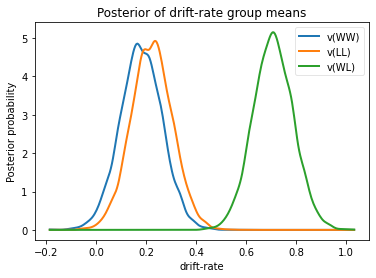

In [24]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[["v(WW)", "v(LL)", "v(WL)"]]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of drift-rate group means")
# plt.savefig('hddm_demo_fig_06.pdf')

In [25]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.3589
P(LL > WL) =  0.0


In [26]:
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10972.849847
Stimulus model DIC: 10787.043993


## Within-subject effects

In [27]:
from patsy import dmatrix

dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [28]:
def run_m_reg(id, data=None, samples=None, burn=None, save_name="cavanagh2011_reg"):
    import hddm

    dbname = save_name + "_chain_%i.db" % id
    mname = save_name + "_chain_%i" % id

    m = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(
        samples, burn=burn, dbname=dbname, db="pickle"
    )  # it's neccessary to save the model data
    m.save(mname)

    return m

In [29]:
%%time
m_reg_list = p_map(
    partial(run_m_reg, data=data, samples=5000, burn=1000), range(chains)
)

  0%|          | 0/5 [00:00<?, ?it/s]

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f297254a4c0>}
Uses Identity Link
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f297254a4c0>}
Uses Identity Link
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegresso

/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 2 of 5000 complete in 0.5 sec[                  0%                  ] 2 of 5000 complete in 0.6 sec[                  0%                  ] 2 of 5000 complete in 0.7 sec[                  0%                  ] 3 of 5000 complete in 0.8 sec[                  0%                  ] 3 of 5000 complete in 0.9 sec[                  0%                  ] 4 of 5000 complete in 1.2 sec[                  0%                  ] 4 of 5000 complete in 1.3 sec[                  0%                  ] 5 of 5000 complete in 1.4 sec[                  0%                  ] 4 of 5000 complete in 1.5 sec[                  0%                  ] 5 of 5000 complete in 1.5 sec[                  0%                  ] 7 of 5000 complete in 1.8 sec[                  0%                  ] 8 of 5000 complete in 2.0 sec[                  0%                  ] 7 of 5000 complete in 2.0 sec[                  0%                  ] 7 of 5000 complete in 2.2 sec[                  

                   1%                  ] 78 of 5000 complete in 18.2 secc[                  1%                  ] 68 of 5000 complete in 16.2 sec[                  1%                  ] 69 of 5000 complete in 16.2 sec[                  1%                  ] 69 of 5000 complete in 16.4 sec[                  1%                  ] 71 of 5000 complete in 16.4 sec[                  1%                  ] 70 of 5000 complete in 16.7 sec[                  1%                  ] 70 of 5000 complete in 16.7 sec[                  1%                  ] 73 of 5000 complete in 16.9 sec[                  1%                  ] 72 of 5000 complete in 16.9 sec[                  1%                  ] 72 of 5000 complete in 17.1 sec[                  1%                  ] 73 of 5000 complete in 17.4 sec[                  1%                  ] 73 of 5000 complete in 17.4 sec[                  1%                  ] 76 of 5000 complete in 17.6 sec[                  1%                  ] 75 of 5000 complete in

 [-                 2%                  ] 132 of 5000 complete in 31.1 sec[-                 2%                  ] 132 of 5000 complete in 31.1 sec[-                 2%                  ] 135 of 5000 complete in 31.2 sec[-                 2%                  ] 134 of 5000 complete in 31.3 sec [-                 2%                  ] 135 of 5000 complete in 31.8 sec [-                 2%                  ] 135 of 5000 complete in 31.8 sec[-                 2%                  ] 135 of 5000 complete in 31.8 sec[-                 2%                  ] 138 of 5000 complete in 31.8 sec[-                 2%                  ] 137 of 5000 complete in 32.0 sec[-                 2%                  ] 137 of 5000 complete in 32.3 sec[-                 2%                  ] 138 of 5000 complete in 32.4 sec[-                 2%                  ] 138 of 5000 complete in 32.5 sec[-                 2%                  ] 141 of 5000 complete in 32.5 sec[-                 2%                  ] 140 of 

 [-                 3%                  ] 197 of 5000 complete in 46.2 sec[-                 4%                  ] 201 of 5000 complete in 46.3 sec[-                 4%                  ] 200 of 5000 complete in 46.5 sec[-                 3%                  ] 197 of 5000 complete in 46.5 sec[-                 4%                  ] 201 of 5000 complete in 46.7 sec[-                 4%                  ] 203 of 5000 complete in 46.9 sec[-                 4%                  ] 200 of 5000 complete in 46.9 sec[-                 4%                  ] 203 of 5000 complete in 47.2 sec[-                 4%                  ] 200 of 5000 complete in 47.2 sec[-                 4%                  ] 203 of 5000 complete in 47.2 sec[-                 4%                  ] 206 of 5000 complete in 47.5 sec[-                 4%                  ] 203 of 5000 complete in 47.6 sec[-                 4%                  ] 202 of 5000 complete in 47.8 sec[-                 4%                  ] 206 of 50

 [--                5%                  ] 265 of 5000 complete in 61.5 sec[--                5%                  ] 266 of 5000 complete in 61.5 sec[-                 5%                  ] 263 of 5000 complete in 61.8 sec[--                5%                  ] 268 of 5000 complete in 61.8 sec[--                5%                  ] 266 of 5000 complete in 61.9 sec[--                5%                  ] 268 of 5000 complete in 62.1 sec[--                5%                  ] 269 of 5000 complete in 62.1 sec[--                5%                  ] 266 of 5000 complete in 62.5 sec[--                5%                  ] 271 of 5000 complete in 62.5 sec[--                5%                  ] 269 of 5000 complete in 62.6 sec[--                5%                  ] 271 of 5000 complete in 62.9 sec[--                5%                  ] 272 of 5000 complete in 62.8 sec[--                5%                  ] 269 of 5000 complete in 63.1 sec[--                5%                  ] 274 of 50

 --                7%                  ] 382 of 5000 complete in 88.9 secc[--                6%                  ] 331 of 5000 complete in 76.7 sec[--                6%                  ] 330 of 5000 complete in 76.8 sec[--                6%                  ] 333 of 5000 complete in 76.9 sec[--                6%                  ] 335 of 5000 complete in 77.0 sec[--                6%                  ] 331 of 5000 complete in 77.3 sec[--                6%                  ] 334 of 5000 complete in 77.4 sec[--                6%                  ] 333 of 5000 complete in 77.5 sec[--                6%                  ] 336 of 5000 complete in 77.6 sec[--                6%                  ] 338 of 5000 complete in 77.6 sec[--                6%                  ] 334 of 5000 complete in 78.0 sec[--                6%                  ] 337 of 5000 complete in 78.1 sec[--                6%                  ] 336 of 5000 complete in 78.2 sec[--                6%                  ] 341 of 50

 [---               7%                  ] 397 of 5000 complete in 92.0 sec[---               7%                  ] 395 of 5000 complete in 92.0 sec[---               8%                  ] 401 of 5000 complete in 92.3 sec[---               7%                  ] 398 of 5000 complete in 92.3 sec[---               7%                  ] 398 of 5000 complete in 92.5 sec[---               8%                  ] 400 of 5000 complete in 92.7 sec[---               7%                  ] 398 of 5000 complete in 92.8 sec[---               8%                  ] 404 of 5000 complete in 93.0 sec[---               8%                  ] 401 of 5000 complete in 93.0 sec[---               8%                  ] 401 of 5000 complete in 93.2 sec[---               8%                  ] 403 of 5000 complete in 93.3 sec[---               8%                  ] 401 of 5000 complete in 93.4 sec[---               8%                  ] 407 of 5000 complete in 93.6 sec[---               8%                  ] 404 of 50

 [---               9%                  ] 460 of 5000 complete in 106.9 sec[---               9%                  ] 461 of 5000 complete in 107.0 sec[---               9%                  ] 466 of 5000 complete in 107.2 sec[---               9%                  ] 463 of 5000 complete in 107.5 sec[---               9%                  ] 462 of 5000 complete in 107.6 sec[---               9%                  ] 465 of 5000 complete in 107.6 sec[---               9%                  ] 463 of 5000 complete in 107.6 sec[---               9%                  ] 469 of 5000 complete in 107.9 sec[---               9%                  ] 466 of 5000 complete in 108.2 sec[---               9%                  ] 466 of 5000 complete in 108.2 sec[---               9%                  ] 468 of 5000 complete in 108.3 sec[---               9%                  ] 465 of 5000 complete in 108.2 sec[---               9%                  ] 472 of 5000 complete in 108.5 sec[---               9%                

 ----             11%                  ] 555 of 5000 complete in 128.5 secc[---              10%                  ] 526 of 5000 complete in 122.1 sec[----             10%                  ] 528 of 5000 complete in 122.1 sec[----             10%                  ] 528 of 5000 complete in 122.3 sec[----             10%                  ] 528 of 5000 complete in 122.4 sec[----             10%                  ] 534 of 5000 complete in 122.6 sec[----             10%                  ] 529 of 5000 complete in 122.8 sec[----             10%                  ] 531 of 5000 complete in 122.8 sec[----             10%                  ] 531 of 5000 complete in 123.0 sec[----             10%                  ] 531 of 5000 complete in 123.1 sec[----             10%                  ] 537 of 5000 complete in 123.3 sec[----             10%                  ] 532 of 5000 complete in 123.4 sec[----             10%                  ] 534 of 5000 complete in 123.5 sec[----             10%                

 [----             11%                  ] 593 of 5000 complete in 137.1 sec[----             11%                  ] 594 of 5000 complete in 137.2 sec[----             11%                  ] 597 of 5000 complete in 137.4 sec[----             11%                  ] 594 of 5000 complete in 137.5 sec[----             11%                  ] 596 of 5000 complete in 137.9 sec[----             11%                  ] 596 of 5000 complete in 137.8 sec[----             11%                  ] 597 of 5000 complete in 137.9 sec[----             12%                  ] 600 of 5000 complete in 138.0 sec[----             11%                  ] 597 of 5000 complete in 138.2 sec[----             11%                  ] 599 of 5000 complete in 138.6 sec[----             11%                  ] 599 of 5000 complete in 138.5 sec[----             12%                  ] 600 of 5000 complete in 138.6 sec[----             12%                  ] 603 of 5000 complete in 138.7 sec[----             12%                

 [-----            13%                  ] 659 of 5000 complete in 152.1 sec[-----            13%                  ] 659 of 5000 complete in 152.4 sec[-----            13%                  ] 663 of 5000 complete in 152.6 sec[-----            13%                  ] 661 of 5000 complete in 152.7 sec[-----            13%                  ] 662 of 5000 complete in 152.8 sec[-----            13%                  ] 661 of 5000 complete in 152.9 sec[-----            13%                  ] 662 of 5000 complete in 153.1 sec[-----            13%                  ] 666 of 5000 complete in 153.3 sec[-----            13%                  ] 664 of 5000 complete in 153.4 sec[-----            13%                  ] 665 of 5000 complete in 153.5 sec[-----            13%                  ] 664 of 5000 complete in 153.6 sec[-----            13%                  ] 665 of 5000 complete in 153.8 sec[-----            13%                  ] 669 of 5000 complete in 153.9 sec[-----            13%                

 -----            14%                  ] 740 of 5000 complete in 170.4 secc[-----            14%                  ] 724 of 5000 complete in 167.2 sec[-----            14%                  ] 726 of 5000 complete in 167.2 sec[-----            14%                  ] 724 of 5000 complete in 167.4 sec[-----            14%                  ] 725 of 5000 complete in 167.6 sec[-----            14%                  ] 725 of 5000 complete in 167.7 sec[-----            14%                  ] 727 of 5000 complete in 167.9 sec[-----            14%                  ] 729 of 5000 complete in 167.9 sec[-----            14%                  ] 727 of 5000 complete in 168.1 sec[-----            14%                  ] 728 of 5000 complete in 168.3 sec[-----            14%                  ] 728 of 5000 complete in 168.4 sec[-----            14%                  ] 730 of 5000 complete in 168.6 sec[-----            14%                  ] 732 of 5000 complete in 168.6 sec[-----            14%                

 [-----            15%                  ] 789 of 5000 complete in 182.0 sec[-----            15%                  ] 788 of 5000 complete in 182.1 sec[------           15%                  ] 792 of 5000 complete in 182.3 sec[-----            15%                  ] 789 of 5000 complete in 182.4 sec[------           15%                  ] 792 of 5000 complete in 182.6 sec[------           15%                  ] 790 of 5000 complete in 182.7 sec[------           15%                  ] 791 of 5000 complete in 182.8 sec[------           15%                  ] 795 of 5000 complete in 183.0 sec[------           15%                  ] 792 of 5000 complete in 183.1 sec[------           15%                  ] 795 of 5000 complete in 183.3 sec[------           15%                  ] 793 of 5000 complete in 183.4 sec[------           15%                  ] 794 of 5000 complete in 183.5 sec[------           15%                  ] 798 of 5000 complete in 183.7 sec[------           15%                

 [------           17%                  ] 854 of 5000 complete in 196.7 sec[------           17%                  ] 855 of 5000 complete in 196.9 sec[------           17%                  ] 854 of 5000 complete in 197.2 sec[------           17%                  ] 853 of 5000 complete in 197.3 sec[------           17%                  ] 854 of 5000 complete in 197.3 sec[------           17%                  ] 857 of 5000 complete in 197.5 sec[------           17%                  ] 858 of 5000 complete in 197.7 sec[------           17%                  ] 857 of 5000 complete in 197.9 sec[------           17%                  ] 856 of 5000 complete in 198.0 sec[------           17%                  ] 857 of 5000 complete in 198.1 sec[------           17%                  ] 860 of 5000 complete in 198.1 sec[------           17%                  ] 861 of 5000 complete in 198.4 sec[------           17%                  ] 860 of 5000 complete in 198.5 sec[------           17%                

 [------           18%                  ] 920 of 5000 complete in 211.9 sec[------           18%                  ] 918 of 5000 complete in 212.1 sec[------           18%                  ] 917 of 5000 complete in 212.0 sec  [------           18%                  ] 919 of 5000 complete in 212.1 sec[------           18%                  ] 920 of 5000 complete in 212.1 sec[-------          18%                  ] 923 of 5000 complete in 212.5 sec[------           18%                  ] 920 of 5000 complete in 212.7 sec[-------          18%                  ] 922 of 5000 complete in 212.7 sec[------           18%                  ] 921 of 5000 complete in 212.8 sec[-------          18%                  ] 923 of 5000 complete in 212.8 sec[-------          18%                  ] 926 of 5000 complete in 213.2 sec  [-------          18%                  ] 925 of 5000 complete in 213.4 sec[-------          18%                  ] 923 of 5000 complete in 213.4 sec[-------          18%            

 -------          20%                  ] 1045 of 5000 complete in 241.4 sec[-------          19%                  ] 985 of 5000 complete in 227.1 sec[-------          19%                  ] 984 of 5000 complete in 227.1 sec[-------          19%                  ] 986 of 5000 complete in 227.2 sec[-------          19%                  ] 984 of 5000 complete in 227.3 sec[-------          19%                  ] 987 of 5000 complete in 227.6 sec[-------          19%                  ] 988 of 5000 complete in 227.8 sec[-------          19%                  ] 987 of 5000 complete in 227.8 sec[-------          19%                  ] 989 of 5000 complete in 227.9 sec[-------          19%                  ] 987 of 5000 complete in 228.0 sec[-------          19%                  ] 990 of 5000 complete in 228.3 sec[-------          19%                  ] 991 of 5000 complete in 228.6 sec[-------          19%                  ] 990 of 5000 complete in 228.5 sec[-------          19%                

 [-------          20%                  ] 1048 of 5000 complete in 241.8 sec[-------          21%                  ] 1050 of 5000 complete in 241.9 sec[-------          20%                  ] 1048 of 5000 complete in 242.1 sec[-------          20%                  ] 1049 of 5000 complete in 242.2 sec[-------          21%                  ] 1050 of 5000 complete in 242.2 sec[-------          21%                  ] 1051 of 5000 complete in 242.4 sec[--------         21%                  ] 1053 of 5000 complete in 242.6 sec[-------          21%                  ] 1051 of 5000 complete in 242.7 sec[-------          21%                  ] 1052 of 5000 complete in 242.9 sec[--------         21%                  ] 1053 of 5000 complete in 242.9 sec[--------         21%                  ] 1054 of 5000 complete in 243.1 sec[--------         21%                  ] 1056 of 5000 complete in 243.2 sec[--------         21%                  ] 1053 of 5000 complete in 243.2 sec[--------         21%   

 [--------         22%                  ] 1111 of 5000 complete in 256.4 sec[--------         22%                  ] 1111 of 5000 complete in 256.5 sec[--------         22%                  ] 1113 of 5000 complete in 256.6 sec[--------         22%                  ] 1112 of 5000 complete in 256.8 sec[--------         22%                  ] 1115 of 5000 complete in 256.9 sec[--------         22%                  ] 1114 of 5000 complete in 257.1 sec[--------         22%                  ] 1114 of 5000 complete in 257.2 sec[--------         22%                  ] 1116 of 5000 complete in 257.3 sec[--------         22%                  ] 1115 of 5000 complete in 257.5 sec[--------         22%                  ] 1118 of 5000 complete in 257.5 sec[--------         22%                  ] 1117 of 5000 complete in 257.7 sec[--------         22%                  ] 1117 of 5000 complete in 257.9 sec[--------         22%                  ] 1119 of 5000 complete in 258.0 sec[--------         22%   

 [--------         23%                  ] 1176 of 5000 complete in 271.3 sec[--------         23%                  ] 1175 of 5000 complete in 271.3 sec[--------         23%                  ] 1177 of 5000 complete in 271.4 sec[--------         23%                  ] 1179 of 5000 complete in 271.8 sec[--------         23%                  ] 1177 of 5000 complete in 271.9 sec[--------         23%                  ] 1179 of 5000 complete in 272.0 sec[--------         23%                  ] 1178 of 5000 complete in 271.9 sec[--------         23%                  ] 1180 of 5000 complete in 272.0 sec[--------         23%                  ] 1180 of 5000 complete in 272.6 sec[--------         23%                  ] 1182 of 5000 complete in 272.6 sec[--------         23%                  ] 1182 of 5000 complete in 272.6 sec[--------         23%                  ] 1181 of 5000 complete in 272.6 sec[--------         23%                  ] 1183 of 5000 complete in 272.7 sec[--------         23%   

 ---------        25%                  ] 1266 of 5000 complete in 291.6 secc[---------        24%                  ] 1242 of 5000 complete in 286.3 sec[---------        24%                  ] 1240 of 5000 complete in 286.2 sec[---------        24%                  ] 1241 of 5000 complete in 286.3 sec[---------        24%                  ] 1241 of 5000 complete in 286.7 sec[---------        24%                  ] 1245 of 5000 complete in 286.8 sec[---------        24%                  ] 1245 of 5000 complete in 286.9 sec[---------        24%                  ] 1243 of 5000 complete in 286.9 sec[---------        24%                  ] 1244 of 5000 complete in 287.0 sec[---------        24%                  ] 1244 of 5000 complete in 287.4 sec[---------        24%                  ] 1248 of 5000 complete in 287.5 sec[---------        24%                  ] 1246 of 5000 complete in 287.6 sec[---------        24%                  ] 1248 of 5000 complete in 287.7 sec[---------        24%   

 [---------        26%                  ] 1301 of 5000 complete in 300.7 sec[---------        26%                  ] 1304 of 5000 complete in 300.8 sec[---------        26%                  ] 1305 of 5000 complete in 301.0 sec[---------        26%                  ] 1307 of 5000 complete in 301.1 sec[---------        26%                  ] 1308 of 5000 complete in 301.3 sec[---------        26%                  ] 1306 of 5000 complete in 301.3 sec[---------        26%                  ] 1304 of 5000 complete in 301.5 sec[---------        26%                  ] 1308 of 5000 complete in 301.7 sec[---------        26%                  ] 1310 of 5000 complete in 301.7 sec[---------        26%                  ] 1311 of 5000 complete in 301.9 sec[---------        26%                  ] 1309 of 5000 complete in 302.0 sec[---------        26%                  ] 1307 of 5000 complete in 302.2 sec[---------        26%                  ] 1312 of 5000 complete in 302.3 sec[---------        26%   

 [----------       27%                  ] 1370 of 5000 complete in 315.5 sec[----------       27%                  ] 1368 of 5000 complete in 315.6 sec[----------       27%                  ] 1370 of 5000 complete in 315.6 sec[----------       27%                  ] 1368 of 5000 complete in 315.6 sec[----------       27%                  ] 1368 of 5000 complete in 316.1 sec[----------       27%                  ] 1373 of 5000 complete in 316.2 sec[----------       27%                  ] 1371 of 5000 complete in 316.2 sec[----------       27%                  ] 1371 of 5000 complete in 316.3 sec[----------       27%                  ] 1373 of 5000 complete in 316.3 sec[----------       27%                  ] 1370 of 5000 complete in 316.6 sec[----------       27%                  ] 1373 of 5000 complete in 316.8 sec[----------       27%                  ] 1376 of 5000 complete in 316.9 sec[----------       27%                  ] 1374 of 5000 complete in 317.0 sec[----------       27%   

 [----------       28%                  ] 1430 of 5000 complete in 329.9 sec[----------       28%                  ] 1434 of 5000 complete in 330.1 sec[----------       28%                  ] 1431 of 5000 complete in 330.2 sec[----------       28%                  ] 1435 of 5000 complete in 330.4 sec  [----------       28%                  ] 1430 of 5000 complete in 330.5 sec[----------       28%                  ] 1432 of 5000 complete in 330.4 sec[----------       28%                  ] 1437 of 5000 complete in 330.8 sec[----------       28%                  ] 1434 of 5000 complete in 330.9 sec[----------       28%                  ] 1438 of 5000 complete in 331.1 sec[----------       28%                  ] 1433 of 5000 complete in 331.2 sec[----------       28%                  ] 1435 of 5000 complete in 331.2 sec[----------       28%                  ] 1440 of 5000 complete in 331.5 sec[----------       28%                  ] 1437 of 5000 complete in 331.6 sec[----------       28% 

 [-----------      29%                  ] 1498 of 5000 complete in 344.7 sec[-----------      29%                  ] 1494 of 5000 complete in 344.8 sec[-----------      29%                  ] 1497 of 5000 complete in 344.8 sec[-----------      29%                  ] 1494 of 5000 complete in 345.0 sec[-----------      29%                  ] 1495 of 5000 complete in 345.0 sec[-----------      30%                  ] 1501 of 5000 complete in 345.3 sec[-----------      30%                  ] 1500 of 5000 complete in 345.5 sec[-----------      29%                  ] 1497 of 5000 complete in 345.5 sec[-----------      29%                  ] 1497 of 5000 complete in 345.7 sec[-----------      29%                  ] 1498 of 5000 complete in 345.7 sec[-----------      30%                  ] 1504 of 5000 complete in 346.0 sec[-----------      30%                  ] 1503 of 5000 complete in 346.2 sec[-----------      30%                  ] 1500 of 5000 complete in 346.2 sec[-----------      30%   

 [-----------      31%                  ] 1561 of 5000 complete in 359.4 sec[-----------      31%                  ] 1558 of 5000 complete in 359.6 sec[-----------      31%                  ] 1557 of 5000 complete in 359.6 sec[-----------      31%                  ] 1563 of 5000 complete in 359.7 sec[-----------      31%                  ] 1559 of 5000 complete in 360.1 sec[-----------      31%                  ] 1564 of 5000 complete in 360.1 sec[-----------      31%                  ] 1561 of 5000 complete in 360.3 sec[-----------      31%                  ] 1560 of 5000 complete in 360.3 sec[-----------      31%                  ] 1566 of 5000 complete in 360.4 sec[-----------      31%                  ] 1562 of 5000 complete in 360.8 sec[-----------      31%                  ] 1567 of 5000 complete in 360.8 sec[-----------      31%                  ] 1564 of 5000 complete in 361.0 sec[-----------      31%                  ] 1563 of 5000 complete in 360.9 sec[-----------      31%   

 [------------     32%                  ] 1625 of 5000 complete in 374.1 sec[------------     32%                  ] 1622 of 5000 complete in 374.5 sec[------------     32%                  ] 1623 of 5000 complete in 374.6 sec[------------     32%                  ] 1621 of 5000 complete in 374.7 sec[------------     32%                  ] 1626 of 5000 complete in 374.6 sec[------------     32%                  ] 1628 of 5000 complete in 374.8 sec[------------     32%                  ] 1625 of 5000 complete in 375.1 sec[------------     32%                  ] 1625 of 5000 complete in 375.2 sec[------------     32%                  ] 1629 of 5000 complete in 375.3 sec[------------     32%                  ] 1624 of 5000 complete in 375.4 sec[------------     32%                  ] 1631 of 5000 complete in 375.5 sec[------------     32%                  ] 1628 of 5000 complete in 375.8 sec[------------     32%                  ] 1628 of 5000 complete in 375.9 sec[------------     32%   

 -------------    35%                  ] 1755 of 5000 complete in 403.5 secc[------------     33%                  ] 1686 of 5000 complete in 389.3 sec[------------     33%                  ] 1693 of 5000 complete in 389.4 sec[------------     33%                  ] 1687 of 5000 complete in 389.5 sec[------------     33%                  ] 1692 of 5000 complete in 389.5 sec[------------     33%                  ] 1684 of 5000 complete in 389.6 sec[------------     33%                  ] 1689 of 5000 complete in 390.0 sec[------------     33%                  ] 1689 of 5000 complete in 390.0 sec[------------     33%                  ] 1696 of 5000 complete in 390.1 sec[------------     33%                  ] 1695 of 5000 complete in 390.3 sec[------------     33%                  ] 1687 of 5000 complete in 390.3 sec[------------     33%                  ] 1692 of 5000 complete in 390.7 sec[------------     33%                  ] 1692 of 5000 complete in 390.7 sec[------------     33%   

 [-------------    35%                  ] 1755 of 5000 complete in 404.1 sec[-------------    35%                  ] 1750 of 5000 complete in 404.2 sec[-------------    35%                  ] 1758 of 5000 complete in 404.2 sec[-------------    35%                  ] 1751 of 5000 complete in 404.2 sec[-------------    34%                  ] 1748 of 5000 complete in 404.5 sec[-------------    35%                  ] 1758 of 5000 complete in 404.7 sec[-------------    35%                  ] 1753 of 5000 complete in 404.8 sec[-------------    35%                  ] 1761 of 5000 complete in 404.9 sec[-------------    35%                  ] 1754 of 5000 complete in 404.9 sec[-------------    35%                  ] 1751 of 5000 complete in 405.2 sec[-------------    35%                  ] 1756 of 5000 complete in 405.4 sec[-------------    35%                  ] 1761 of 5000 complete in 405.4 sec[-------------    35%                  ] 1764 of 5000 complete in 405.6 sec[-------------    35%   

 [-------------    36%                  ] 1820 of 5000 complete in 418.6 sec[-------------    36%                  ] 1814 of 5000 complete in 418.9 sec[-------------    36%                  ] 1812 of 5000 complete in 419.1 sec[-------------    36%                  ] 1820 of 5000 complete in 419.1 sec[-------------    36%                  ] 1815 of 5000 complete in 419.1 sec[-------------    36%                  ] 1823 of 5000 complete in 419.3 sec[-------------    36%                  ] 1816 of 5000 complete in 419.5 sec[-------------    36%                  ] 1815 of 5000 complete in 419.8 sec[-------------    36%                  ] 1823 of 5000 complete in 419.8 sec[-------------    36%                  ] 1818 of 5000 complete in 419.8 sec[-------------    36%                  ] 1826 of 5000 complete in 420.0 sec[-------------    36%                  ] 1819 of 5000 complete in 420.2 sec[-------------    36%                  ] 1818 of 5000 complete in 420.5 sec[-------------    36%   

 [--------------   37%                  ] 1877 of 5000 complete in 433.7 sec[--------------   37%                  ] 1882 of 5000 complete in 433.7 sec[--------------   37%                  ] 1877 of 5000 complete in 433.8 sec[--------------   37%                  ] 1879 of 5000 complete in 433.8 sec[--------------   37%                  ] 1888 of 5000 complete in 434.2 sec[--------------   37%                  ] 1880 of 5000 complete in 434.4 sec[--------------   37%                  ] 1885 of 5000 complete in 434.4 sec[--------------   37%                  ] 1880 of 5000 complete in 434.5 sec[--------------   37%                  ] 1882 of 5000 complete in 434.5 sec[--------------   37%                  ] 1891 of 5000 complete in 434.9 sec[--------------   37%                  ] 1883 of 5000 complete in 435.1 sec[--------------   37%                  ] 1888 of 5000 complete in 435.1 sec[--------------   37%                  ] 1883 of 5000 complete in 435.2 sec[--------------   37%   

 [--------------   38%                  ] 1940 of 5000 complete in 448.3 sec[--------------   38%                  ] 1949 of 5000 complete in 448.4 sec[--------------   38%                  ] 1946 of 5000 complete in 448.4 sec[--------------   38%                  ] 1945 of 5000 complete in 448.8 sec[--------------   38%                  ] 1943 of 5000 complete in 449.0 sec[--------------   38%                  ] 1943 of 5000 complete in 449.0 sec[--------------   39%                  ] 1952 of 5000 complete in 449.1 sec[--------------   38%                  ] 1949 of 5000 complete in 449.1 sec[--------------   38%                  ] 1948 of 5000 complete in 449.5 sec[--------------   38%                  ] 1946 of 5000 complete in 449.7 sec[--------------   38%                  ] 1946 of 5000 complete in 449.7 sec[--------------   39%                  ] 1952 of 5000 complete in 449.7 sec[--------------   39%                  ] 1955 of 5000 complete in 449.8 sec[--------------   39%   

 [---------------  40%                  ] 2006 of 5000 complete in 463.1 sec[---------------  40%                  ] 2005 of 5000 complete in 463.3 sec[---------------  40%                  ] 2014 of 5000 complete in 463.6 sec[---------------  40%                  ] 2012 of 5000 complete in 463.6 sec[---------------  40%                  ] 2007 of 5000 complete in 463.8 sec[---------------  40%                  ] 2009 of 5000 complete in 463.8 sec[---------------  40%                  ] 2008 of 5000 complete in 463.9 sec[---------------  40%                  ] 2017 of 5000 complete in 464.3 sec[---------------  40%                  ] 2015 of 5000 complete in 464.3 sec[---------------  40%                  ] 2010 of 5000 complete in 464.4 sec[---------------  40%                  ] 2012 of 5000 complete in 464.5 sec[---------------  40%                  ] 2011 of 5000 complete in 464.6 sec[---------------  40%                  ] 2012 of 5000 complete in 464.9 sec[---------------  40%   

 [---------------  41%                  ] 2071 of 5000 complete in 478.1 sec[---------------  41%                  ] 2072 of 5000 complete in 478.2 sec[---------------  41%                  ] 2077 of 5000 complete in 478.3 sec[---------------  41%                  ] 2071 of 5000 complete in 478.5 sec[---------------  41%                  ] 2077 of 5000 complete in 478.6 sec[---------------  41%                  ] 2079 of 5000 complete in 478.8 sec[---------------  41%                  ] 2074 of 5000 complete in 478.8 sec[---------------  41%                  ] 2075 of 5000 complete in 478.9 sec[---------------  41%                  ] 2074 of 5000 complete in 479.1 sec[---------------  41%                  ] 2080 of 5000 complete in 479.3 sec[---------------  41%                  ] 2082 of 5000 complete in 479.5 sec[---------------  41%                  ] 2078 of 5000 complete in 479.5 sec[---------------  41%                  ] 2077 of 5000 complete in 479.5 sec[---------------  41%   

 [---------------- 42%                  ] 2138 of 5000 complete in 492.7 sec[---------------- 42%                  ] 2136 of 5000 complete in 493.1 sec[---------------- 42%                  ] 2137 of 5000 complete in 493.2 sec[---------------- 42%                  ] 2141 of 5000 complete in 493.3 sec[---------------- 42%                  ] 2141 of 5000 complete in 493.4 sec[---------------- 42%                  ] 2138 of 5000 complete in 493.4 sec[---------------- 42%                  ] 2139 of 5000 complete in 493.8 sec[---------------- 42%                  ] 2140 of 5000 complete in 493.9 sec[---------------- 42%                  ] 2144 of 5000 complete in 494.1 sec[---------------- 42%                  ] 2144 of 5000 complete in 494.0 sec[---------------- 42%                  ] 2141 of 5000 complete in 494.1 sec[---------------- 42%                  ] 2142 of 5000 complete in 494.5 sec[---------------- 42%                  ] 2143 of 5000 complete in 494.5 sec[---------------- 42%   

 [---------------- 44%                  ] 2202 of 5000 complete in 507.6 sec[---------------- 44%                  ] 2200 of 5000 complete in 507.6 sec[---------------- 44%                  ] 2204 of 5000 complete in 507.7 sec[---------------- 44%                  ] 2201 of 5000 complete in 507.9 sec[---------------- 44%                  ] 2201 of 5000 complete in 508.0 sec[---------------- 44%                  ] 2203 of 5000 complete in 508.2 sec[---------------- 44%                  ] 2205 of 5000 complete in 508.4 sec[---------------- 44%                  ] 2207 of 5000 complete in 508.4 sec[---------------- 44%                  ] 2203 of 5000 complete in 508.4 sec[---------------- 44%                  ] 2204 of 5000 complete in 508.7 sec[---------------- 44%                  ] 2205 of 5000 complete in 508.8 sec[---------------- 44%                  ] 2208 of 5000 complete in 509.0 sec[---------------- 44%                  ] 2206 of 5000 complete in 509.1 sec[---------------- 44%   

 [-----------------45%                  ] 2265 of 5000 complete in 522.2 sec[-----------------45%                  ] 2267 of 5000 complete in 522.4 sec[-----------------45%                  ] 2264 of 5000 complete in 522.6 sec[-----------------45%                  ] 2265 of 5000 complete in 522.7 sec[-----------------45%                  ] 2267 of 5000 complete in 522.8 sec[-----------------45%                  ] 2268 of 5000 complete in 523.0 sec[-----------------45%                  ] 2270 of 5000 complete in 523.1 sec[-----------------45%                  ] 2267 of 5000 complete in 523.3 sec[-----------------45%                  ] 2268 of 5000 complete in 523.4 sec[-----------------45%                  ] 2270 of 5000 complete in 523.5 sec[-----------------45%                  ] 2271 of 5000 complete in 523.7 sec[-----------------45%                  ] 2273 of 5000 complete in 523.7 sec[-----------------45%                  ] 2270 of 5000 complete in 524.0 sec[-----------------45%   

 [-----------------46%                  ] 2329 of 5000 complete in 536.9 sec[-----------------46%                  ] 2327 of 5000 complete in 537.4 sec[-----------------46%                  ] 2332 of 5000 complete in 537.3 sec[-----------------46%                  ] 2332 of 5000 complete in 537.6 sec[-----------------46%                  ] 2332 of 5000 complete in 537.6 sec[-----------------46%                  ] 2329 of 5000 complete in 537.7 sec[-----------------46%                  ] 2330 of 5000 complete in 538.1 sec[-----------------46%                  ] 2335 of 5000 complete in 538.0 sec[-----------------46%                  ] 2335 of 5000 complete in 538.3 sec[-----------------46%                  ] 2332 of 5000 complete in 538.4 sec[-----------------46%                  ] 2335 of 5000 complete in 538.4 sec[-----------------46%                  ] 2333 of 5000 complete in 538.8 sec[-----------------46%                  ] 2338 of 5000 complete in 538.7 sec[-----------------46%   

 [-----------------47%                  ] 2390 of 5000 complete in 551.8 sec[-----------------47%                  ] 2396 of 5000 complete in 552.0 sec[-----------------47%                  ] 2391 of 5000 complete in 552.1 sec[-----------------47%                  ] 2395 of 5000 complete in 552.1 sec[-----------------47%                  ] 2396 of 5000 complete in 552.4 sec[-----------------47%                  ] 2393 of 5000 complete in 552.5 sec[-----------------47%                  ] 2397 of 5000 complete in 552.6 sec[-----------------47%                  ] 2399 of 5000 complete in 552.7 sec[-----------------47%                  ] 2394 of 5000 complete in 552.8 sec[-----------------47%                  ] 2398 of 5000 complete in 552.9 sec[-----------------47%                  ] 2396 of 5000 complete in 553.2 sec[-----------------48%                  ] 2400 of 5000 complete in 553.3 sec[-----------------48%                  ] 2402 of 5000 complete in 553.3 sec[-----------------47%   

 [-----------------49%                  ] 2453 of 5000 complete in 566.4 sec[-----------------49%                  ] 2453 of 5000 complete in 566.4 sec[-----------------49%                  ] 2460 of 5000 complete in 566.4 sec[-----------------49%                  ] 2459 of 5000 complete in 566.7 sec[-----------------49%                  ] 2460 of 5000 complete in 566.8 sec[-----------------49%                  ] 2456 of 5000 complete in 567.1 sec[-----------------49%                  ] 2463 of 5000 complete in 567.0 sec[-----------------49%                  ] 2456 of 5000 complete in 567.1 sec[-----------------49%                  ] 2462 of 5000 complete in 567.4 sec[-----------------49%                  ] 2463 of 5000 complete in 567.5 sec[-----------------49%                  ] 2459 of 5000 complete in 567.7 sec[-----------------49%                  ] 2466 of 5000 complete in 567.7 sec[-----------------49%                  ] 2459 of 5000 complete in 567.8 sec[-----------------49%   

 [-----------------50%                  ] 2517 of 5000 complete in 580.9 sec[-----------------50%                  ] 2522 of 5000 complete in 581.2 sec[-----------------50%                  ] 2525 of 5000 complete in 581.2 sec[-----------------50%                  ] 2518 of 5000 complete in 581.3 sec[-----------------50%                  ] 2522 of 5000 complete in 581.5 sec[-----------------50%                  ] 2520 of 5000 complete in 581.6 sec[-----------------50%                  ] 2524 of 5000 complete in 581.7 sec[-----------------50%                  ] 2528 of 5000 complete in 581.9 sec[-----------------50%                  ] 2521 of 5000 complete in 582.0 sec[-----------------50%                  ] 2526 of 5000 complete in 582.3 sec[-----------------50%                  ] 2525 of 5000 complete in 582.2 sec[-----------------50%                  ] 2523 of 5000 complete in 582.3 sec[-----------------50%                  ] 2531 of 5000 complete in 582.6 sec[-----------------50%   

 [-----------------51%                  ] 2579 of 5000 complete in 595.4 sec[-----------------51%                  ] 2586 of 5000 complete in 595.9 sec[-----------------51%                  ] 2584 of 5000 complete in 595.9 sec[-----------------51%                  ] 2590 of 5000 complete in 596.1 sec[-----------------51%                  ] 2582 of 5000 complete in 596.2 sec[-----------------51%                  ] 2582 of 5000 complete in 596.2 sec[-----------------51%                  ] 2589 of 5000 complete in 596.6 sec[-----------------51%                  ] 2587 of 5000 complete in 596.6 sec[-----------------51%                  ] 2584 of 5000 complete in 596.7 sec[-----------------51%                  ] 2593 of 5000 complete in 596.8 sec[-----------------51%                  ] 2585 of 5000 complete in 596.9 sec[-----------------51%                  ] 2592 of 5000 complete in 597.2 sec[-----------------51%                  ] 2590 of 5000 complete in 597.2 sec[-----------------51%   

 [-----------------53%                  ] 2652 of 5000 complete in 610.3 sec[-----------------52%                  ] 2646 of 5000 complete in 610.4 sec[-----------------53%                  ] 2651 of 5000 complete in 610.9 sec[-----------------52%                  ] 2646 of 5000 complete in 610.9 sec[-----------------52%                  ] 2648 of 5000 complete in 611.0 sec[-----------------53%                  ] 2655 of 5000 complete in 611.0 sec[-----------------52%                  ] 2649 of 5000 complete in 611.2 sec[-----------------53%                  ] 2654 of 5000 complete in 611.6 sec[-----------------52%                  ] 2649 of 5000 complete in 611.6 sec[-----------------53%                  ] 2651 of 5000 complete in 611.7 sec[-----------------53%                  ] 2651 of 5000 complete in 611.7 sec[-----------------53%                  ] 2658 of 5000 complete in 611.7 sec [-----------------53%                  ] 2653 of 5000 complete in 612.2 sec [-----------------53% 

 [-----------------54%                  ] 2708 of 5000 complete in 625.2 sec[-----------------54%                  ] 2717 of 5000 complete in 625.2 sec[-----------------54%                  ] 2711 of 5000 complete in 625.5 sec[-----------------54%                  ] 2710 of 5000 complete in 625.6 sec[-----------------54%                  ] 2716 of 5000 complete in 625.8 sec[-----------------54%                  ] 2711 of 5000 complete in 625.9 sec[-----------------54%                  ] 2720 of 5000 complete in 625.9 sec[-----------------54%                  ] 2714 of 5000 complete in 626.2 sec[-----------------54%                  ] 2718 of 5000 complete in 626.3 sec[-----------------54%                  ] 2713 of 5000 complete in 626.3 sec[-----------------54%                  ] 2714 of 5000 complete in 626.5 sec[-----------------54%                  ] 2723 of 5000 complete in 626.6 sec[-----------------54%                  ] 2717 of 5000 complete in 626.9 sec[-----------------54%   

 [-----------------55%-                 ] 2782 of 5000 complete in 639.9 sec[-----------------55%-                 ] 2773 of 5000 complete in 640.1 sec[-----------------55%-                 ] 2774 of 5000 complete in 640.2 sec[-----------------55%-                 ] 2776 of 5000 complete in 640.4 sec[-----------------55%-                 ] 2780 of 5000 complete in 640.5 sec[-----------------55%-                 ] 2785 of 5000 complete in 640.5 sec[-----------------55%-                 ] 2776 of 5000 complete in 640.8 sec[-----------------55%-                 ] 2777 of 5000 complete in 640.8 sec[-----------------55%-                 ] 2779 of 5000 complete in 641.0 sec[-----------------55%-                 ] 2783 of 5000 complete in 641.2 sec[-----------------55%-                 ] 2788 of 5000 complete in 641.2 sec[-----------------55%-                 ] 2780 of 5000 complete in 641.5 sec[-----------------55%-                 ] 2779 of 5000 complete in 641.5 sec[-----------------55%-  

 [-----------------56%-                 ] 2848 of 5000 complete in 654.8 sec[-----------------56%-                 ] 2838 of 5000 complete in 654.9 sec[-----------------56%-                 ] 2840 of 5000 complete in 655.0 sec[-----------------56%-                 ] 2843 of 5000 complete in 655.1 sec[-----------------56%-                 ] 2840 of 5000 complete in 655.2 sec[-----------------57%-                 ] 2851 of 5000 complete in 655.5 sec[-----------------56%-                 ] 2841 of 5000 complete in 655.6 sec[-----------------56%-                 ] 2843 of 5000 complete in 655.7 sec[-----------------56%-                 ] 2846 of 5000 complete in 655.7 sec[-----------------56%-                 ] 2843 of 5000 complete in 655.8 sec[-----------------57%-                 ] 2854 of 5000 complete in 656.1 sec[-----------------56%-                 ] 2846 of 5000 complete in 656.3 sec[-----------------56%-                 ] 2844 of 5000 complete in 656.3 sec[-----------------56%-  

 [-----------------58%--                ] 2902 of 5000 complete in 669.5 sec[-----------------58%--                ] 2903 of 5000 complete in 669.6 sec[-----------------58%--                ] 2906 of 5000 complete in 669.9 sec[-----------------58%--                ] 2915 of 5000 complete in 670.1 sec[-----------------58%--                ] 2908 of 5000 complete in 670.2 sec[-----------------58%--                ] 2905 of 5000 complete in 670.2 sec[-----------------58%--                ] 2906 of 5000 complete in 670.3 sec[-----------------58%--                ] 2909 of 5000 complete in 670.6 sec[-----------------58%--                ] 2918 of 5000 complete in 670.8 sec[-----------------58%--                ] 2911 of 5000 complete in 670.9 sec[-----------------58%--                ] 2908 of 5000 complete in 670.9 sec[-----------------58%--                ] 2909 of 5000 complete in 671.0 sec[-----------------58%--                ] 2912 of 5000 complete in 671.3 sec[-----------------58%-- 

 [-----------------59%--                ] 2966 of 5000 complete in 684.2 sec[-----------------59%--                ] 2968 of 5000 complete in 684.5 sec[-----------------59%--                ] 2970 of 5000 complete in 684.6 sec[-----------------59%--                ] 2971 of 5000 complete in 684.9 sec[-----------------59%--                ] 2969 of 5000 complete in 684.9 sec[-----------------59%--                ] 2981 of 5000 complete in 684.9 sec[-----------------59%--                ] 2971 of 5000 complete in 685.1 sec[-----------------59%--                ] 2973 of 5000 complete in 685.3 sec[-----------------59%--                ] 2983 of 5000 complete in 685.4 sec[-----------------59%--                ] 2974 of 5000 complete in 685.6 sec[-----------------59%--                ] 2972 of 5000 complete in 685.6 sec[-----------------59%--                ] 2974 of 5000 complete in 685.9 sec[-----------------59%--                ] 2976 of 5000 complete in 685.9 sec[-----------------59%-- 

 -----------------62%---               ] 3101 of 5000 complete in 712.9 secc  [-----------------60%---               ] 3034 of 5000 complete in 699.2 sec[-----------------60%---               ] 3042 of 5000 complete in 699.1 sec[-----------------60%---               ] 3035 of 5000 complete in 699.7 sec[-----------------60%---               ] 3034 of 5000 complete in 699.7 sec[-----------------60%---               ] 3035 of 5000 complete in 699.7 sec[-----------------60%---               ] 3045 of 5000 complete in 699.8 sec[-----------------60%---               ] 3037 of 5000 complete in 699.9 sec[-----------------60%---               ] 3038 of 5000 complete in 700.3 sec[-----------------60%---               ] 3038 of 5000 complete in 700.4 sec[-----------------60%---               ] 3037 of 5000 complete in 700.4 sec[-----------------60%---               ] 3048 of 5000 complete in 700.5 sec[-----------------60%---               ] 3040 of 5000 complete in 700.6 sec[-----------------60%-

 [-----------------61%---               ] 3098 of 5000 complete in 714.0 sec[-----------------61%---               ] 3098 of 5000 complete in 714.4 sec[-----------------62%---               ] 3107 of 5000 complete in 714.4 sec[-----------------61%---               ] 3098 of 5000 complete in 714.5 sec[-----------------62%---               ] 3101 of 5000 complete in 714.6 sec[-----------------62%---               ] 3101 of 5000 complete in 714.6 sec[-----------------62%---               ] 3100 of 5000 complete in 715.0 sec[-----------------62%---               ] 3110 of 5000 complete in 715.0 sec[-----------------62%---               ] 3101 of 5000 complete in 715.1 sec[-----------------62%---               ] 3104 of 5000 complete in 715.2 sec[-----------------62%---               ] 3104 of 5000 complete in 715.3 sec[-----------------62%---               ] 3103 of 5000 complete in 715.7 sec[-----------------62%---               ] 3113 of 5000 complete in 715.7 sec[-----------------62%---

 [-----------------63%----              ] 3162 of 5000 complete in 728.7 sec[-----------------63%----              ] 3165 of 5000 complete in 729.1 sec[-----------------63%----              ] 3160 of 5000 complete in 729.1 sec[-----------------63%----              ] 3170 of 5000 complete in 729.1 sec[-----------------63%----              ] 3163 of 5000 complete in 729.3 sec[-----------------63%----              ] 3165 of 5000 complete in 729.4 sec[-----------------63%----              ] 3162 of 5000 complete in 729.6 sec[-----------------63%----              ] 3168 of 5000 complete in 729.8 sec[-----------------63%----              ] 3173 of 5000 complete in 729.8 sec[-----------------63%----              ] 3167 of 5000 complete in 729.9 sec[-----------------63%----              ] 3166 of 5000 complete in 730.0 sec[-----------------63%----              ] 3165 of 5000 complete in 730.3 sec[-----------------63%----              ] 3171 of 5000 complete in 730.5 sec[-----------------63%---

 -----------------65%----              ] 3281 of 5000 complete in 755.7 secc[-----------------64%----              ] 3227 of 5000 complete in 743.8 sec[-----------------64%----              ] 3226 of 5000 complete in 743.8 sec[-----------------64%----              ] 3223 of 5000 complete in 743.8 sec[-----------------64%----              ] 3234 of 5000 complete in 744.1 sec[-----------------64%----              ] 3231 of 5000 complete in 744.3 sec[-----------------64%----              ] 3230 of 5000 complete in 744.5 sec[-----------------64%----              ] 3229 of 5000 complete in 744.5 sec[-----------------64%----              ] 3226 of 5000 complete in 744.5 sec[-----------------64%----              ] 3237 of 5000 complete in 744.8 sec[-----------------64%----              ] 3234 of 5000 complete in 745.1 sec[-----------------64%----              ] 3233 of 5000 complete in 745.2 sec[-----------------64%----              ] 3229 of 5000 complete in 745.2 sec[-----------------64%---

 -----------------66%-----             ] 3327 of 5000 complete in 765.0 secc[-----------------65%-----             ] 3292 of 5000 complete in 759.0 sec[-----------------65%----              ] 3288 of 5000 complete in 759.0 sec[-----------------65%-----             ] 3293 of 5000 complete in 759.1 sec[-----------------65%-----             ] 3296 of 5000 complete in 759.1 sec[-----------------66%-----             ] 3300 of 5000 complete in 759.1 sec[-----------------65%-----             ] 3294 of 5000 complete in 759.5 sec[-----------------65%-----             ] 3290 of 5000 complete in 759.5 sec[-----------------65%-----             ] 3296 of 5000 complete in 759.7 sec[-----------------65%-----             ] 3299 of 5000 complete in 759.8 sec[-----------------66%-----             ] 3303 of 5000 complete in 759.8 sec[-----------------65%-----             ] 3293 of 5000 complete in 760.1 sec[-----------------65%-----             ] 3297 of 5000 complete in 760.2 sec[-----------------65%---

 [-----------------67%-----             ] 3353 of 5000 complete in 773.5 sec[-----------------67%-----             ] 3356 of 5000 complete in 773.6 sec[-----------------67%-----             ] 3365 of 5000 complete in 773.7 sec[-----------------67%-----             ] 3359 of 5000 complete in 773.8 sec[-----------------67%-----             ] 3357 of 5000 complete in 773.9 sec[-----------------67%-----             ] 3367 of 5000 complete in 774.2 sec[-----------------67%-----             ] 3356 of 5000 complete in 774.2 sec[-----------------67%-----             ] 3359 of 5000 complete in 774.3 sec[-----------------67%-----             ] 3362 of 5000 complete in 774.4 sec[-----------------67%-----             ] 3360 of 5000 complete in 774.6 sec[-----------------67%-----             ] 3370 of 5000 complete in 774.9 sec[-----------------67%-----             ] 3359 of 5000 complete in 774.9 sec[-----------------67%-----             ] 3362 of 5000 complete in 775.0 sec[-----------------67%---

 [-----------------68%-----             ] 3418 of 5000 complete in 788.0 sec[-----------------68%-----             ] 3419 of 5000 complete in 788.3 sec[-----------------68%-----             ] 3419 of 5000 complete in 788.5 sec[-----------------68%------            ] 3430 of 5000 complete in 788.6 sec[-----------------68%------            ] 3423 of 5000 complete in 788.7 sec[-----------------68%-----             ] 3421 of 5000 complete in 788.7 sec[-----------------68%-----             ] 3421 of 5000 complete in 788.8 sec[-----------------68%------            ] 3432 of 5000 complete in 789.2 sec[-----------------68%------            ] 3422 of 5000 complete in 789.2 sec[-----------------68%------            ] 3426 of 5000 complete in 789.4 sec[-----------------68%------            ] 3424 of 5000 complete in 789.4 sec[-----------------68%------            ] 3424 of 5000 complete in 789.5 sec[-----------------68%------            ] 3435 of 5000 complete in 789.9 sec[-----------------68%---

 [-----------------69%------            ] 3481 of 5000 complete in 802.6 sec[-----------------69%------            ] 3492 of 5000 complete in 802.9 sec[-----------------69%------            ] 3482 of 5000 complete in 803.0 sec[-----------------69%------            ] 3483 of 5000 complete in 803.1 sec[-----------------69%------            ] 3487 of 5000 complete in 803.2 sec[-----------------69%------            ] 3484 of 5000 complete in 803.3 sec[-----------------69%------            ] 3495 of 5000 complete in 803.6 sec[-----------------69%------            ] 3485 of 5000 complete in 803.7 sec[-----------------69%------            ] 3486 of 5000 complete in 803.7 sec[-----------------69%------            ] 3486 of 5000 complete in 803.8 sec[-----------------69%------            ] 3490 of 5000 complete in 804.0 sec[-----------------69%------            ] 3498 of 5000 complete in 804.3 sec[-----------------69%------            ] 3488 of 5000 complete in 804.3 sec[-----------------69%---

 [-----------------70%------            ] 3544 of 5000 complete in 817.3 sec[-----------------70%------            ] 3545 of 5000 complete in 817.5 sec[-----------------70%------            ] 3546 of 5000 complete in 817.7 sec[-----------------71%-------           ] 3555 of 5000 complete in 817.8 sec[-----------------71%------            ] 3552 of 5000 complete in 818.0 sec[-----------------70%------            ] 3547 of 5000 complete in 818.0 sec[-----------------70%------            ] 3548 of 5000 complete in 818.2 sec[-----------------70%------            ] 3549 of 5000 complete in 818.3 sec[-----------------71%-------           ] 3554 of 5000 complete in 818.5 sec[-----------------71%-------           ] 3558 of 5000 complete in 818.5 sec[-----------------71%------            ] 3550 of 5000 complete in 818.8 sec[-----------------71%------            ] 3551 of 5000 complete in 818.8 sec[-----------------71%-------           ] 3556 of 5000 complete in 819.1 sec[-----------------71%---

 [-----------------72%-------           ] 3618 of 5000 complete in 832.0 sec[-----------------72%-------           ] 3608 of 5000 complete in 832.3 sec[-----------------72%-------           ] 3609 of 5000 complete in 832.4 sec[-----------------72%-------           ] 3610 of 5000 complete in 832.4 sec[-----------------72%-------           ] 3614 of 5000 complete in 832.7 sec[-----------------72%-------           ] 3621 of 5000 complete in 832.7 sec[-----------------72%-------           ] 3611 of 5000 complete in 833.0 sec[-----------------72%-------           ] 3612 of 5000 complete in 833.1 sec[-----------------72%-------           ] 3613 of 5000 complete in 833.1 sec[-----------------72%-------           ] 3617 of 5000 complete in 833.4 sec[-----------------72%-------           ] 3624 of 5000 complete in 833.4 sec[-----------------72%-------           ] 3614 of 5000 complete in 833.7 sec[-----------------72%-------           ] 3615 of 5000 complete in 833.8 sec[-----------------72%---

 [-----------------73%-------           ] 3671 of 5000 complete in 847.0 sec[-----------------73%-------           ] 3671 of 5000 complete in 847.1 sec[-----------------73%-------           ] 3677 of 5000 complete in 847.2 sec[-----------------73%-------           ] 3675 of 5000 complete in 847.3 sec[-----------------73%--------          ] 3686 of 5000 complete in 847.4 sec[-----------------73%-------           ] 3674 of 5000 complete in 847.7 sec[-----------------73%-------           ] 3674 of 5000 complete in 847.8 sec[-----------------73%-------           ] 3680 of 5000 complete in 847.9 sec[-----------------73%-------           ] 3678 of 5000 complete in 848.0 sec[-----------------73%--------          ] 3689 of 5000 complete in 848.1 sec[-----------------73%-------           ] 3677 of 5000 complete in 848.3 sec[-----------------73%-------           ] 3677 of 5000 complete in 848.4 sec[-----------------73%-------           ] 3683 of 5000 complete in 848.6 sec[-----------------73%---

 [-----------------74%--------          ] 3735 of 5000 complete in 861.7 sec[-----------------74%--------          ] 3735 of 5000 complete in 861.8 sec[-----------------74%--------          ] 3737 of 5000 complete in 861.8 sec[-----------------74%--------          ] 3742 of 5000 complete in 862.2 sec[-----------------75%--------          ] 3750 of 5000 complete in 862.1 sec[-----------------74%--------          ] 3739 of 5000 complete in 862.3 sec[-----------------74%--------          ] 3738 of 5000 complete in 862.4 sec[-----------------74%--------          ] 3738 of 5000 complete in 862.5 sec[-----------------74%--------          ] 3745 of 5000 complete in 862.8 sec[-----------------75%--------          ] 3753 of 5000 complete in 862.8 sec[-----------------74%--------          ] 3741 of 5000 complete in 862.8 sec[-----------------74%--------          ] 3741 of 5000 complete in 863.1 sec[-----------------74%--------          ] 3741 of 5000 complete in 863.1 sec[-----------------75%---

 [-----------------75%--------          ] 3798 of 5000 complete in 876.3 sec[-----------------76%--------          ] 3804 of 5000 complete in 876.5 sec[-----------------75%--------          ] 3799 of 5000 complete in 876.4 sec[-----------------76%--------          ] 3815 of 5000 complete in 876.7 sec[-----------------76%--------          ] 3800 of 5000 complete in 876.8 sec[-----------------76%--------          ] 3803 of 5000 complete in 876.9 sec[-----------------76%--------          ] 3807 of 5000 complete in 877.1 sec[-----------------76%--------          ] 3802 of 5000 complete in 877.1 sec[-----------------76%---------         ] 3818 of 5000 complete in 877.4 sec[-----------------76%--------          ] 3803 of 5000 complete in 877.5 sec[-----------------76%--------          ] 3806 of 5000 complete in 877.6 sec[-----------------76%--------          ] 3805 of 5000 complete in 877.8 sec[-----------------76%--------          ] 3810 of 5000 complete in 877.8 sec[-----------------76%---

 [-----------------77%---------         ] 3863 of 5000 complete in 891.1 sec[-----------------77%---------         ] 3865 of 5000 complete in 891.2 sec[-----------------77%---------         ] 3878 of 5000 complete in 891.3 sec[-----------------77%---------         ] 3868 of 5000 complete in 891.4 sec[-----------------77%---------         ] 3865 of 5000 complete in 891.4 sec[-----------------77%---------         ] 3866 of 5000 complete in 891.8 sec[-----------------77%---------         ] 3870 of 5000 complete in 891.9 sec[-----------------77%---------         ] 3881 of 5000 complete in 891.9 sec[-----------------77%---------         ] 3868 of 5000 complete in 891.9 sec[-----------------77%---------         ] 3868 of 5000 complete in 892.1 sec[-----------------77%---------         ] 3869 of 5000 complete in 892.5 sec[-----------------77%---------         ] 3873 of 5000 complete in 892.6 sec[-----------------77%---------         ] 3884 of 5000 complete in 892.6 sec[-----------------77%---

 [-----------------78%---------         ] 3929 of 5000 complete in 905.7 sec[-----------------78%---------         ] 3942 of 5000 complete in 905.9 sec[-----------------78%---------         ] 3928 of 5000 complete in 906.0 sec[-----------------78%---------         ] 3930 of 5000 complete in 906.2 sec[-----------------78%---------         ] 3932 of 5000 complete in 906.4 sec[-----------------78%---------         ] 3930 of 5000 complete in 906.4 sec[-----------------78%---------         ] 3945 of 5000 complete in 906.6 sec[-----------------78%---------         ] 3931 of 5000 complete in 906.7 sec[-----------------78%---------         ] 3933 of 5000 complete in 906.9 sec[-----------------78%---------         ] 3935 of 5000 complete in 907.0 sec[-----------------78%---------         ] 3933 of 5000 complete in 907.0 sec[-----------------78%---------         ] 3934 of 5000 complete in 907.3 sec[-----------------78%----------        ] 3948 of 5000 complete in 907.3 sec[-----------------78%---

 [-----------------80%----------        ] 4005 of 5000 complete in 920.5 sec[-----------------79%----------        ] 3993 of 5000 complete in 920.7 sec[-----------------79%----------        ] 3993 of 5000 complete in 920.8 sec[-----------------79%----------        ] 3992 of 5000 complete in 920.9 sec[-----------------79%----------        ] 3996 of 5000 complete in 921.2 sec[-----------------80%----------        ] 4008 of 5000 complete in 921.2 sec[-----------------79%----------        ] 3996 of 5000 complete in 921.4 sec[-----------------79%----------        ] 3995 of 5000 complete in 921.5 sec[-----------------79%----------        ] 3996 of 5000 complete in 921.6 sec[-----------------79%----------        ] 3999 of 5000 complete in 921.9 sec[-----------------80%----------        ] 4011 of 5000 complete in 921.8 sec[-----------------79%----------        ] 3999 of 5000 complete in 922.1 sec[-----------------79%----------        ] 3998 of 5000 complete in 922.1 sec[-----------------79%---

 [-----------------81%----------        ] 4058 of 5000 complete in 935.5 sec[-----------------81%----------        ] 4056 of 5000 complete in 935.6 sec[-----------------81%----------        ] 4071 of 5000 complete in 935.6 sec[-----------------81%----------        ] 4060 of 5000 complete in 935.7 sec[-----------------81%----------        ] 4057 of 5000 complete in 935.8 sec[-----------------81%----------        ] 4061 of 5000 complete in 936.2 sec[-----------------81%----------        ] 4074 of 5000 complete in 936.2 sec[-----------------81%----------        ] 4059 of 5000 complete in 936.2 sec[-----------------81%----------        ] 4063 of 5000 complete in 936.4 sec[-----------------81%----------        ] 4060 of 5000 complete in 936.5 sec[-----------------81%----------        ] 4064 of 5000 complete in 936.9 sec[-----------------81%----------        ] 4077 of 5000 complete in 936.9 sec[-----------------81%----------        ] 4062 of 5000 complete in 936.9 sec[-----------------81%---

 [-----------------82%-----------       ] 4134 of 5000 complete in 950.0 sec[-----------------82%-----------       ] 4120 of 5000 complete in 950.4 sec[-----------------82%-----------       ] 4124 of 5000 complete in 950.5 sec[-----------------82%-----------       ] 4136 of 5000 complete in 950.5 sec[-----------------82%-----------       ] 4120 of 5000 complete in 950.6 sec[-----------------82%-----------       ] 4123 of 5000 complete in 950.8 sec[-----------------82%-----------       ] 4126 of 5000 complete in 951.0 sec[-----------------82%-----------       ] 4123 of 5000 complete in 951.0 sec[-----------------82%-----------       ] 4139 of 5000 complete in 951.3 sec[-----------------82%-----------       ] 4123 of 5000 complete in 951.3 sec[-----------------82%-----------       ] 4126 of 5000 complete in 951.5 sec[-----------------82%-----------       ] 4128 of 5000 complete in 951.5 sec[-----------------82%-----------       ] 4126 of 5000 complete in 951.7 sec[-----------------82%---

 -----------------84%------------      ] 4236 of 5000 complete in 977.5 secc[-----------------83%-----------       ] 4182 of 5000 complete in 965.0 sec[-----------------83%-----------       ] 4184 of 5000 complete in 965.1 sec[-----------------83%-----------       ] 4184 of 5000 complete in 965.1 sec[-----------------83%-----------       ] 4187 of 5000 complete in 965.4 sec[-----------------84%-----------       ] 4202 of 5000 complete in 965.7 sec [-----------------83%-----------       ] 4185 of 5000 complete in 965.7 sec[-----------------83%-----------       ] 4187 of 5000 complete in 965.8 sec[-----------------83%-----------       ] 4190 of 5000 complete in 966.1 sec[-----------------84%-----------       ] 4205 of 5000 complete in 966.4 sec[-----------------83%-----------       ] 4188 of 5000 complete in 966.4 sec[-----------------83%-----------       ] 4190 of 5000 complete in 966.5 sec[-----------------83%-----------       ] 4190 of 5000 complete in 966.6 sec[-----------------83%--

 -----------------85%------------      ] 4288 of 5000 complete in 988.9 secc[-----------------85%------------      ] 4252 of 5000 complete in 980.3 sec[-----------------85%------------      ] 4267 of 5000 complete in 980.6 sec[-----------------85%------------      ] 4252 of 5000 complete in 980.7 sec[-----------------85%------------      ] 4253 of 5000 complete in 980.8 sec[-----------------85%------------      ] 4254 of 5000 complete in 980.8 sec[-----------------85%------------      ] 4251 of 5000 complete in 980.9 sec[-----------------85%------------      ] 4269 of 5000 complete in 981.1 sec[-----------------85%------------      ] 4255 of 5000 complete in 981.4 sec[-----------------85%------------      ] 4257 of 5000 complete in 981.5 sec[-----------------85%------------      ] 4256 of 5000 complete in 981.5 sec[-----------------85%------------      ] 4254 of 5000 complete in 981.6 sec[-----------------85%------------      ] 4272 of 5000 complete in 981.8 sec[-----------------85%---

 [-----------------86%------------      ] 4312 of 5000 complete in 994.9 sec[-----------------86%------------      ] 4314 of 5000 complete in 995.0 sec[-----------------86%------------      ] 4315 of 5000 complete in 995.0 sec[-----------------86%------------      ] 4319 of 5000 complete in 995.3 sec[-----------------86%------------      ] 4331 of 5000 complete in 995.5 sec[-----------------86%------------      ] 4317 of 5000 complete in 995.7 sec[-----------------86%------------      ] 4315 of 5000 complete in 995.6 sec[-----------------86%------------      ] 4318 of 5000 complete in 995.7 sec[-----------------86%------------      ] 4322 of 5000 complete in 996.1 sec[-----------------86%------------      ] 4334 of 5000 complete in 996.2 sec[-----------------86%------------      ] 4320 of 5000 complete in 996.3 sec[-----------------86%------------      ] 4318 of 5000 complete in 996.3 sec[-----------------86%------------      ] 4321 of 5000 complete in 996.4 sec[-----------------86%---

 -----------------87%-------------     ] 4387 of 5000 complete in 1010.9 secc[-----------------87%-------------     ] 4379 of 5000 complete in 1009.5 sec[-----------------87%-------------     ] 4376 of 5000 complete in 1009.8 sec[-----------------87%-------------     ] 4379 of 5000 complete in 1010.0 sec[-----------------87%-------------     ] 4384 of 5000 complete in 1010.2 sec[-----------------87%-------------     ] 4396 of 5000 complete in 1010.2 sec[-----------------87%-------------     ] 4382 of 5000 complete in 1010.3 sec[-----------------87%-------------     ] 4379 of 5000 complete in 1010.5 sec[-----------------87%-------------     ] 4382 of 5000 complete in 1010.6 sec [-----------------87%-------------     ] 4399 of 5000 complete in 1010.8 sec[-----------------87%-------------     ] 4385 of 5000 complete in 1010.9 sec[-----------------87%-------------     ] 4382 of 5000 complete in 1011.2 sec[-----------------87%-------------     ] 4385 of 5000 complete in 1011.3 sec[---------

 [-----------------89%-------------     ] 4456 of 5000 complete in 1024.1 sec[-----------------88%-------------     ] 4443 of 5000 complete in 1024.2 sec[-----------------88%-------------     ] 4444 of 5000 complete in 1024.2 sec[-----------------88%-------------     ] 4441 of 5000 complete in 1024.4 sec[-----------------88%-------------     ] 4440 of 5000 complete in 1024.6 sec[-----------------88%-------------     ] 4445 of 5000 complete in 1024.7 sec[-----------------89%-------------     ] 4459 of 5000 complete in 1024.8 sec[-----------------88%-------------     ] 4447 of 5000 complete in 1024.9 sec[-----------------88%-------------     ] 4444 of 5000 complete in 1025.1 sec[-----------------88%-------------     ] 4443 of 5000 complete in 1025.2 sec[-----------------88%-------------     ] 4448 of 5000 complete in 1025.4 sec[-----------------89%-------------     ] 4462 of 5000 complete in 1025.5 sec[-----------------88%-------------     ] 4446 of 5000 complete in 1025.6 sec[----------

 -----------------90%--------------    ] 4548 of 5000 complete in 1048.8 secc[-----------------90%--------------    ] 4501 of 5000 complete in 1038.5 sec[-----------------90%--------------    ] 4507 of 5000 complete in 1038.9 sec[-----------------90%--------------    ] 4507 of 5000 complete in 1039.0 sec[-----------------90%--------------    ] 4505 of 5000 complete in 1039.1 sec[-----------------90%--------------    ] 4521 of 5000 complete in 1039.2 sec[-----------------90%--------------    ] 4504 of 5000 complete in 1039.2 sec[-----------------90%--------------    ] 4507 of 5000 complete in 1039.6 sec[-----------------90%--------------    ] 4510 of 5000 complete in 1039.7 sec[-----------------90%--------------    ] 4510 of 5000 complete in 1039.7 sec[-----------------90%--------------    ] 4524 of 5000 complete in 1039.9 sec[-----------------90%--------------    ] 4507 of 5000 complete in 1039.9 sec[-----------------90%--------------    ] 4509 of 5000 complete in 1040.1 sec[----------

 [-----------------91%--------------    ] 4569 of 5000 complete in 1053.1 sec[-----------------91%--------------    ] 4581 of 5000 complete in 1053.1 sec[-----------------91%--------------    ] 4566 of 5000 complete in 1053.4 sec[-----------------91%--------------    ] 4568 of 5000 complete in 1053.5 sec[-----------------91%--------------    ] 4583 of 5000 complete in 1053.6 sec[-----------------91%--------------    ] 4569 of 5000 complete in 1053.7 sec[-----------------91%--------------    ] 4572 of 5000 complete in 1053.8 sec[-----------------91%--------------    ] 4570 of 5000 complete in 1054.0 sec[-----------------91%--------------    ] 4569 of 5000 complete in 1054.2 sec[-----------------91%--------------    ] 4571 of 5000 complete in 1054.2 sec[-----------------91%--------------    ] 4586 of 5000 complete in 1054.3 sec[-----------------91%--------------    ] 4575 of 5000 complete in 1054.5 sec[-----------------91%--------------    ] 4573 of 5000 complete in 1054.7 sec[----------

 [-----------------92%---------------   ] 4628 of 5000 complete in 1067.6 sec[-----------------92%---------------   ] 4628 of 5000 complete in 1067.6 sec[-----------------92%---------------   ] 4644 of 5000 complete in 1067.8 sec[-----------------92%---------------   ] 4630 of 5000 complete in 1068.1 sec[-----------------92%---------------   ] 4634 of 5000 complete in 1068.2 sec[-----------------92%---------------   ] 4631 of 5000 complete in 1068.3 sec[-----------------92%---------------   ] 4631 of 5000 complete in 1068.3 sec[-----------------92%---------------   ] 4647 of 5000 complete in 1068.5 sec[-----------------92%---------------   ] 4633 of 5000 complete in 1068.8 sec[-----------------92%---------------   ] 4637 of 5000 complete in 1068.9 sec[-----------------92%---------------   ] 4634 of 5000 complete in 1069.0 sec[-----------------92%---------------   ] 4634 of 5000 complete in 1068.9 sec[-----------------92%---------------   ] 4649 of 5000 complete in 1069.0 sec[----------

 -----------------94%----------------  ] 4742 of 5000 complete in 1094.0 secc[-----------------93%---------------   ] 4694 of 5000 complete in 1082.1 sec[-----------------93%---------------   ] 4691 of 5000 complete in 1082.2 sec[-----------------94%---------------   ] 4707 of 5000 complete in 1082.2 sec[-----------------93%---------------   ] 4693 of 5000 complete in 1082.6 sec[-----------------93%---------------   ] 4694 of 5000 complete in 1082.6 sec[-----------------93%---------------   ] 4697 of 5000 complete in 1082.8 sec[-----------------93%---------------   ] 4694 of 5000 complete in 1082.9 sec[-----------------94%---------------   ] 4710 of 5000 complete in 1082.9 sec[-----------------93%---------------   ] 4696 of 5000 complete in 1083.1 sec[-----------------93%---------------   ] 4696 of 5000 complete in 1083.3 sec[-----------------93%---------------   ] 4697 of 5000 complete in 1083.5 sec[-----------------94%---------------   ] 4700 of 5000 complete in 1083.5 sec[----------

 [-----------------95%----------------  ] 4754 of 5000 complete in 1096.7 sec[-----------------95%----------------  ] 4754 of 5000 complete in 1096.7 sec[-----------------95%----------------  ] 4758 of 5000 complete in 1096.8 sec[-----------------95%----------------  ] 4772 of 5000 complete in 1097.1 sec[-----------------95%----------------  ] 4757 of 5000 complete in 1097.3 sec[-----------------95%----------------  ] 4757 of 5000 complete in 1097.3 sec[-----------------95%----------------  ] 4757 of 5000 complete in 1097.4 sec[-----------------95%----------------  ] 4761 of 5000 complete in 1097.5 sec[-----------------95%----------------  ] 4775 of 5000 complete in 1097.8 sec[-----------------95%----------------  ] 4760 of 5000 complete in 1098.0 sec[-----------------95%----------------  ] 4760 of 5000 complete in 1098.0 sec[-----------------95%----------------  ] 4764 of 5000 complete in 1098.1 sec[-----------------95%----------------  ] 4760 of 5000 complete in 1098.1 sec[----------

 [-----------------96%----------------  ] 4816 of 5000 complete in 1110.7 sec[-----------------96%----------------  ] 4830 of 5000 complete in 1111.0 sec[-----------------96%----------------  ] 4819 of 5000 complete in 1111.1 sec[-----------------96%----------------  ] 4816 of 5000 complete in 1111.1 sec[-----------------96%----------------  ] 4816 of 5000 complete in 1111.1 sec[-----------------96%----------------  ] 4819 of 5000 complete in 1111.4 sec[-----------------96%----------------  ] 4832 of 5000 complete in 1111.5 sec[-----------------96%----------------  ] 4822 of 5000 complete in 1111.7 sec[-----------------96%----------------  ] 4819 of 5000 complete in 1111.8 sec[-----------------96%----------------  ] 4819 of 5000 complete in 1111.8 sec[-----------------96%----------------  ] 4822 of 5000 complete in 1112.1 sec[-----------------96%----------------  ] 4835 of 5000 complete in 1112.2 sec[-----------------96%----------------  ] 4825 of 5000 complete in 1112.4 sec[----------

 [-----------------97%----------------- ] 4893 of 5000 complete in 1125.6 sec[-----------------97%----------------- ] 4882 of 5000 complete in 1125.6 sec[-----------------97%----------------- ] 4879 of 5000 complete in 1125.8 sec[-----------------97%----------------- ] 4881 of 5000 complete in 1125.9 sec[-----------------97%----------------- ] 4880 of 5000 complete in 1125.9 sec[-----------------97%----------------- ] 4885 of 5000 complete in 1126.3 sec[-----------------97%----------------- ] 4896 of 5000 complete in 1126.3 sec[-----------------97%----------------- ] 4882 of 5000 complete in 1126.5 sec[-----------------97%----------------- ] 4882 of 5000 complete in 1126.5 sec[-----------------97%----------------- ] 4884 of 5000 complete in 1126.6 sec[-----------------97%----------------- ] 4888 of 5000 complete in 1127.0 sec[-----------------97%----------------- ] 4899 of 5000 complete in 1127.0 sec[-----------------97%----------------- ] 4885 of 5000 complete in 1127.2 sec[----------

 [-----------------98%----------------- ] 4943 of 5000 complete in 1140.0 sec[-----------------98%----------------- ] 4942 of 5000 complete in 1140.2 sec[-----------------98%----------------- ] 4942 of 5000 complete in 1140.3 sec[-----------------99%----------------- ] 4956 of 5000 complete in 1140.4 sec[-----------------98%----------------- ] 4947 of 5000 complete in 1140.6 sec[-----------------98%----------------- ] 4946 of 5000 complete in 1140.8 sec[-----------------98%----------------- ] 4945 of 5000 complete in 1140.9 sec[-----------------98%----------------- ] 4945 of 5000 complete in 1141.0 sec[-----------------99%----------------- ] 4959 of 5000 complete in 1141.1 sec[-----------------98%----------------- ] 4948 of 5000 complete in 1141.3 sec[-----------------99%----------------- ] 4950 of 5000 complete in 1141.3 sec[-----------------98%----------------- ] 4948 of 5000 complete in 1141.6 sec[-----------------98%----------------- ] 4948 of 5000 complete in 1141.7 sec[----------

Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function <lambda> at 0x7f2971a37550>}
Uses Identity Link
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function <lambda> at 0x7f29726c9700>}
Uses Identity Link
CPU times: user 11.3 s, sys: 3.48 s, total: 14.8 s
Wall time: 19min 19s


In [30]:
m_reg_all = kabuki.utils.concat_models(m_reg_list)

Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function <lambda> at 0x7f2971a37550>}
Uses Identity Link


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

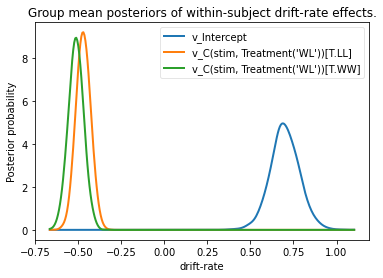

In [31]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[
    [
        "v_Intercept",
        "v_C(stim, Treatment('WL'))[T.LL]",
        "v_C(stim, Treatment('WL'))[T.WW]",
    ],
    "node",
]
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Group mean posteriors of within-subject drift-rate effects.")
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [32]:
%%time
m_reg = hddm.HDDMRegressor(
    data[data.dbs == 0], "a ~ theta:C(conf, Treatment('LC'))", depends_on={"v": "stim"}
)
m_reg.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': " theta:C(conf, Treatment('LC'))", 'params': ['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f296d6f4f70>}
Uses Identity Link
 [-----------------100%-----------------] 5000 of 5000 complete in 1659.7 secCPU times: user 27min 42s, sys: 705 ms, total: 27min 42s
Wall time: 27min 40s


P(a_theta < 0) =  0.048


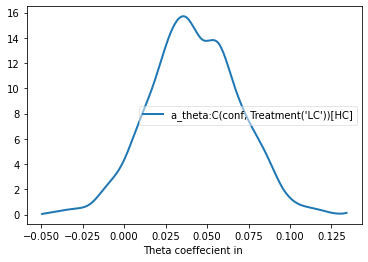

In [33]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel("Theta coeffecient in ")
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [34]:
%%time
m_reg_off = hddm.HDDMRegressor(
    data[data.dbs == 1], "a ~ theta:C(conf, Treatment('LC'))", depends_on={"v": "stim"}
)
m_reg_off.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': " theta:C(conf, Treatment('LC'))", 'params': ['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f296d4108b0>}
Uses Identity Link
 [-----------------100%-----------------] 5000 of 5000 complete in 1608.2 secCPU times: user 26min 50s, sys: 14.2 s, total: 27min 4s
Wall time: 26min 48s


P(a_theta > 0) =  0.048


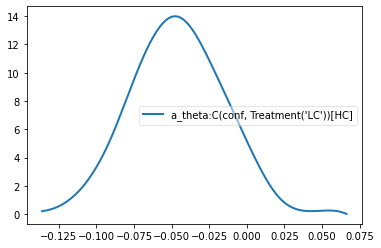

In [35]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

This part of the tutorial seems outdated because, since 0.6.0, HDDM has a default setting `p_outliers=.05`. 

In [36]:
outlier_data, params = hddm.generate.gen_rand_data(
    params={"a": 2, "t": 0.4, "v": 0.5}, size=200, n_fast_outliers=10
)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 7.4 sec

Text(0, 0.5, 'Probability density')

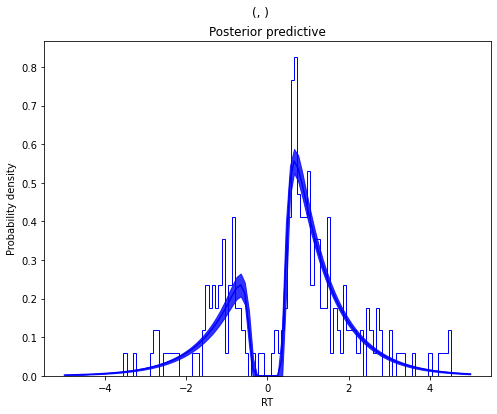

In [38]:
m_no_outlier.plot_posterior_predictive()
plt.title("Posterior predictive")
plt.xlabel("RT")
plt.ylabel("Probability density")
# plt.savefig('hddm_demo_fig_10.pdf')

In [39]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=0.05)
m_outlier.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 7.4 sec

Text(0, 0.5, 'Probability density')

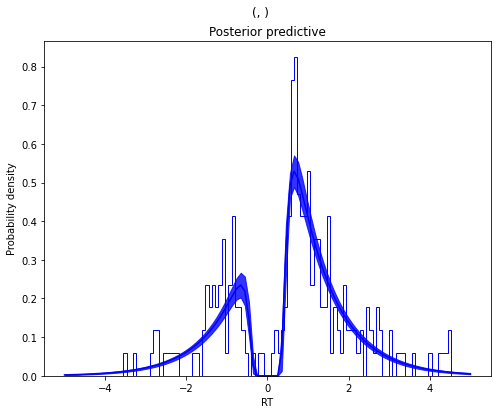

In [40]:
m_outlier.plot_posterior_predictive()
plt.title("Posterior predictive")
plt.xlabel("RT")
plt.ylabel("Probability density")
# plt.savefig('hddm_demo_fig_11.pdf')